# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)
from statsmodels.tsa.stattools import adfuller, kpss

# EDA

## Load dataset

The dataset is taken from here https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality/data and from the web page:

“<i>This dataset contains information about various attributes of a set of fruits, providing insights into their characteristics. The dataset includes details such as fruit ID, size, weight, sweetness, crunchiness, juiciness, ripeness, acidity, and quality.</i>”

In [119]:
#Load the dataset into a dataframe, the data is separated by a comma and the the index column is the 'A_id' one.
df = pd.read_csv('apple_quality.csv', sep=',', index_col=['A_id'])

## Information about the data

On this section we will explorate how is the dataset composed and how many columns and rows does it have. After that we will check the quality of the data investigating on the nan values or the None.

### First look

In [3]:
df.head()

Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
A_id                                                                    
0.0  -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1.0  -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2.0  -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3.0  -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4.0   1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

           Acidity Quality  
A_id                        
0.0   -0.491590483    good  
1.0   -0.722809367    good  
2.0    2.621636473     bad  
3.0    0.790723217    good  
4.0    0.501984036    good

### Size

In [4]:
print(df.shape)

(4001, 8)


The dataset is composed of 4001 rows and 8 columns so in total there are 32008 values.


### Descriptive statistics

Descriptive statistics are numerical and graphical methods used to summarize and describe the main features of a dataset. They provide a concise summary of the essential characteristics, patterns, and trends within the data. Common descriptive statistics include measures of central tendency (mean, median, mode) and measures of variability (range, variance, standard deviation).


In [5]:
df.describe().T

count      mean       std       min       25%       50%  \
Size         4000.0 -0.503015  1.928059 -7.151703 -1.816765 -0.513703   
Weight       4000.0 -0.989547  1.602507 -7.149848 -2.011770 -0.984736   
Sweetness    4000.0 -0.470479  1.943441 -6.894485 -1.738425 -0.504758   
Crunchiness  4000.0  0.985478  1.402757 -6.055058  0.062764  0.998249   
Juiciness    4000.0  0.512118  1.930286 -5.961897 -0.801286  0.534219   
Ripeness     4000.0  0.498277  1.874427 -5.864599 -0.771677  0.503445   

                  75%       max  
Size         0.805526  6.406367  
Weight       0.030976  5.790714  
Sweetness    0.801922  6.374916  
Crunchiness  1.894234  7.619852  
Juiciness    1.835976  7.364403  
Ripeness     1.766212  7.237837

From this is possible to see that we're working with numerical data, note that the Quality column is note on the describe because it is an object value (string) and so it is not possible to see it's statistics yet. The data we are working it is already scaled this is why we have negative values. The author of this dataset did not say which was the transformation but this will simplify the modeling part. Moreover the data has low values, we can see that the highest value is from the Acidity column with a value of 7.404736 and the lowest one is the Size column with -7.151703.

### Data type and Null

The dataframe info command gives us interesting informations about the types of the columns, the number of the null values and the dimension of the dataset.

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4001 entries, 0.0 to nan
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4001 non-null   object 
 7   Quality      4000 non-null   object 
dtypes: float64(6), object(2)
memory usage: 281.3+ KB


From the 4001 entries, we see that there is a null value on all the columns except for the acidity one. To have a better look the command isnull() gives us all the information that we need.

In [8]:
df.isnull().sum()

Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64

All of the features except one have a null value, so an important question comes to our mind: are those nan values in the same row or are those in different rows? To ask this question we need to dig deeper and see where the columns are none.

In [121]:
df[df.Quality.isna()]

Size  Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
A_id                                                              
NaN    NaN     NaN        NaN          NaN        NaN       NaN   

                                Acidity Quality  
A_id                                             
NaN   Created_by_Nidula_Elgiriyewithana     NaN

So this reflects our intuition, all the null values are on the same row, so it's a good choice to remove this row and have a clean dataset to use. If the lecturer is interested in why those rows are null then the .csv file is incorrect on the last line which is this one

“<i>,,,,,,,Created_by_Nidula_Elgiriyewithana,</i>”


In [122]:
df.dropna(inplace=True)

Looking into the null values we see that our dataset is now clean

In [123]:
df.isnull().sum()

Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

A last check to do is to see if there are duplicated rows in the dataset, a lot number of duplicated rows would impact the performance of the models.

In [124]:
df.duplicated().sum()

0

The rows duplicated are zero so we can continue without problems.

### Acidity

The Acidity column is an object type but looking more into the data it's possible to see that all the values are numbers, so it's a good choice to convert the dtype of the column into float64 to be more coincise

In [125]:
df[['Acidity']] = df[['Acidity']].apply(pd.to_numeric, errors='coerce')

### Quality

The quality column is the other one who has a object type, but if we look more closer into the data we see that it's a categorical feature. 

A categorical feature is a type of variable in statistics and machine learning that represents categories or labels. Unlike numerical features, which have values that are numbers and can be treated as quantities, categorical features consist of distinct groups or classes

In [126]:
df.Quality.unique()

array(['good', 'bad'], dtype=object)

The quality columns only assumes two values 'good' or 'bad'. There are a lot of ways to work with categorical data but since we only have two case the label encoding is a simpler solution.

In [127]:
df['Quality'] = df['Quality'].map({'good' : 1, 'bad':0})

Now the dataset should not have columns with dtypes different than float and int.

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0.0 to 3999.0
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float64
 7   Quality      4000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 281.2 KB


And moreover the descriptive statistics for the data look like this.

In [17]:
df.describe().T

count      mean       std       min       25%       50%  \
Size         4000.0 -0.503015  1.928059 -7.151703 -1.816765 -0.513703   
Weight       4000.0 -0.989547  1.602507 -7.149848 -2.011770 -0.984736   
Sweetness    4000.0 -0.470479  1.943441 -6.894485 -1.738425 -0.504758   
Crunchiness  4000.0  0.985478  1.402757 -6.055058  0.062764  0.998249   
Juiciness    4000.0  0.512118  1.930286 -5.961897 -0.801286  0.534219   
Ripeness     4000.0  0.498277  1.874427 -5.864599 -0.771677  0.503445   
Acidity      4000.0  0.076877  2.110270 -7.010538 -1.377424  0.022609   
Quality      4000.0  0.501000  0.500062  0.000000  0.000000  1.000000   

                  75%       max  
Size         0.805526  6.406367  
Weight       0.030976  5.790714  
Sweetness    0.801922  6.374916  
Crunchiness  1.894234  7.619852  
Juiciness    1.835976  7.364403  
Ripeness     1.766212  7.237837  
Acidity      1.510493  7.404736  
Quality      1.000000  1.000000

## Plot of the data

array([[<Axes: xlabel='A_id'>, <Axes: xlabel='A_id'>],
       [<Axes: xlabel='A_id'>, <Axes: xlabel='A_id'>],
       [<Axes: xlabel='A_id'>, <Axes: xlabel='A_id'>],
       [<Axes: xlabel='A_id'>, <Axes: xlabel='A_id'>]], dtype=object)

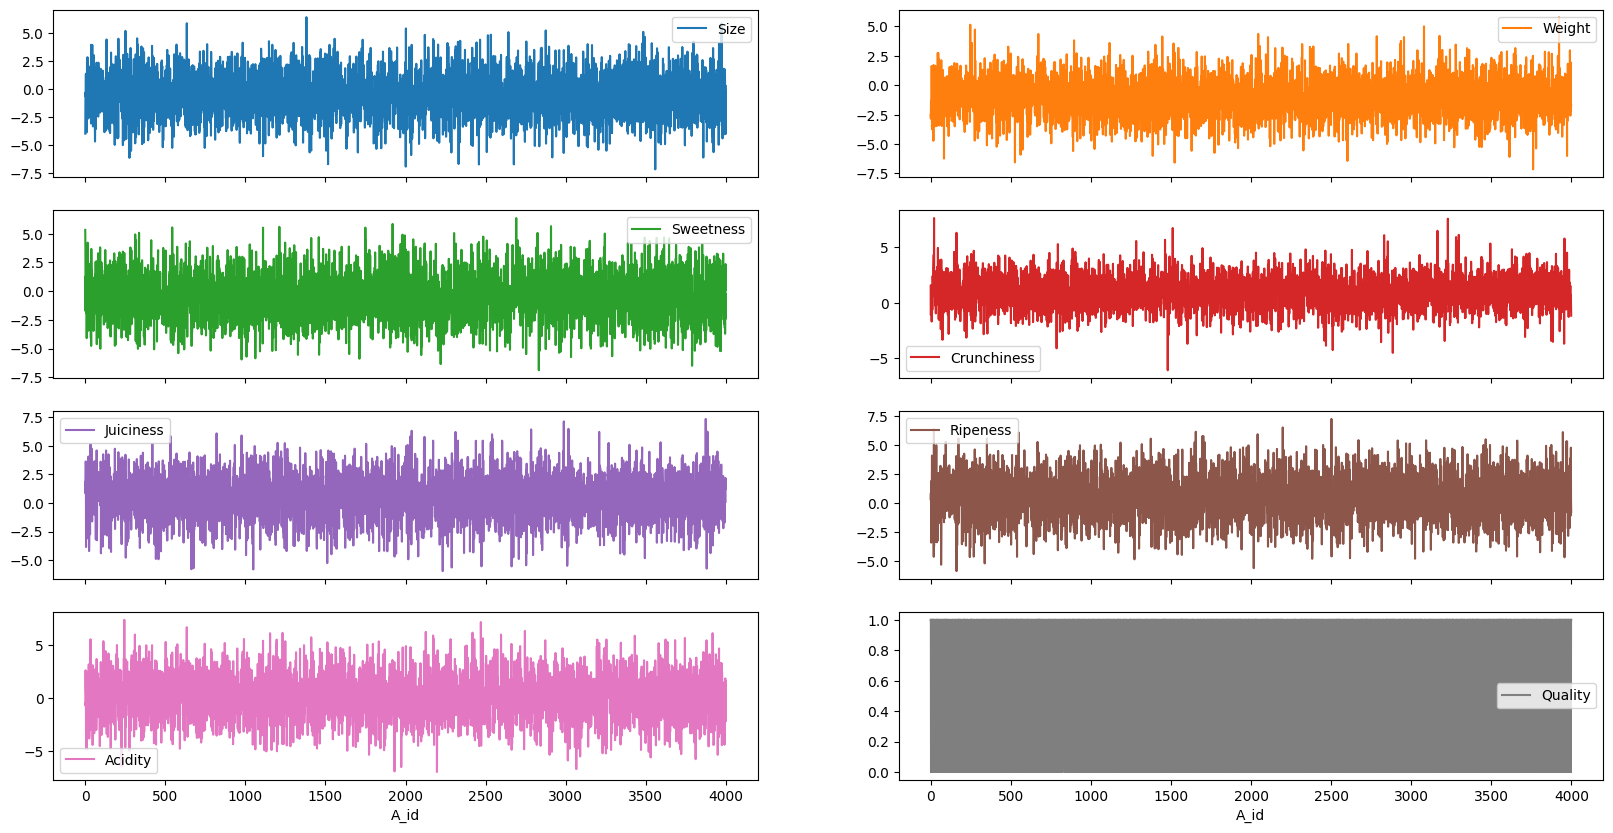

In [18]:
df.plot(subplots = True, figsize=(20,10), layout=(4,2))

From these plots it's not so clear of which type of data we're working with, those graphs seems a lot white noise (https://en.wikipedia.org/wiki/White_noise), the only one who differs is the quality in which only assumes value of 0 and 1 and so it has a rectangular shape as expected.

## Outliers

### Why is it important

Calculating the outliers is important for these reaosns:
* <b>Quality Assurance</b>: Outliers may indicate errors or anomalies in the data collection process. Identifying and addressing these outliers is crucial for ensuring the quality and reliability of the dataset.
* <b>Model Performance</b>: Outliers can significantly impact the performance of statistical and machine learning models. Models may be sensitive to extreme values, leading to skewed predictions. Identifying and handling outliers appropriately can improve the accuracy and robustness of models.
* <b>Insight into Data Distribution</b>: Understanding the distribution of data is essential for making meaningful inferences. Outliers can distort the perception of the central tendency and spread of the data. Estimating outliers helps in gaining a more accurate understanding of the underlying data distribution.
* <b>Data Interpretation</b>: Outliers can have a substantial influence on statistical measures such as mean and standard deviation. By identifying and managing outliers, analysts can provide more accurate interpretations and avoid drawing misleading conclusions based on skewed summary statistics.
* <b>Risk Assessment</b>: In various domains, such as finance or healthcare, outliers may represent significant events or rare occurrences that carry important information.  Detecting and analyzing outliers can aid in risk assessment and decision-making processes.
* <b>Data Cleaning and Preprocessing</b>: Identifying and handling outliers is a critical step in data cleaning and preprocessing. This ensures that the data used for analysis or modeling is more representative of the underlying phenomena, leading to more reliable and meaningful results.

In summary, estimating outliers in data science is essential for ensuring data quality, improving model performance, gaining insights into data distribution, facilitating accurate data interpretation, assessing risks, and enabling effective data preprocessing. It is a crucial aspect of the overall data analysis pipeline.

### BoxPlot of all features

<Axes: >

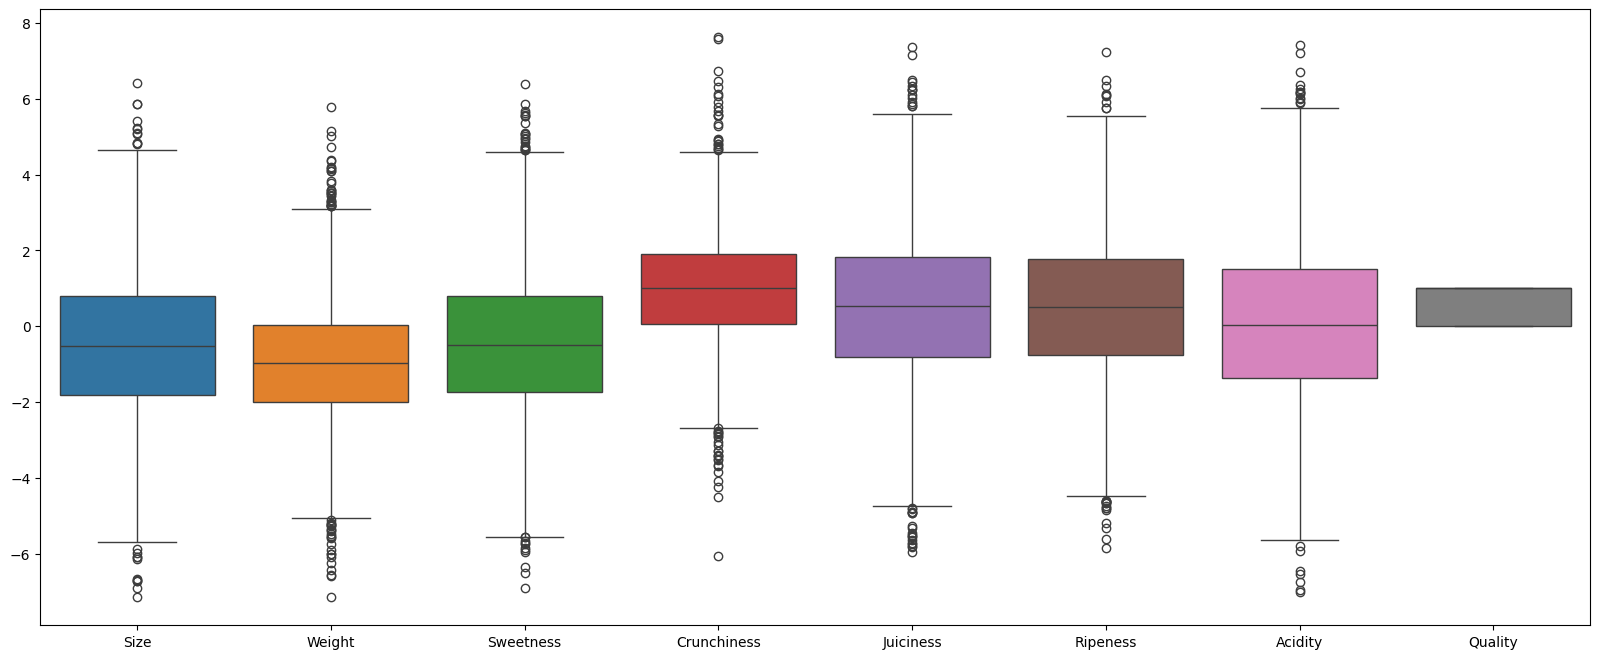

In [19]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(df) 

### Boxplots of each feature considering the good and bad part

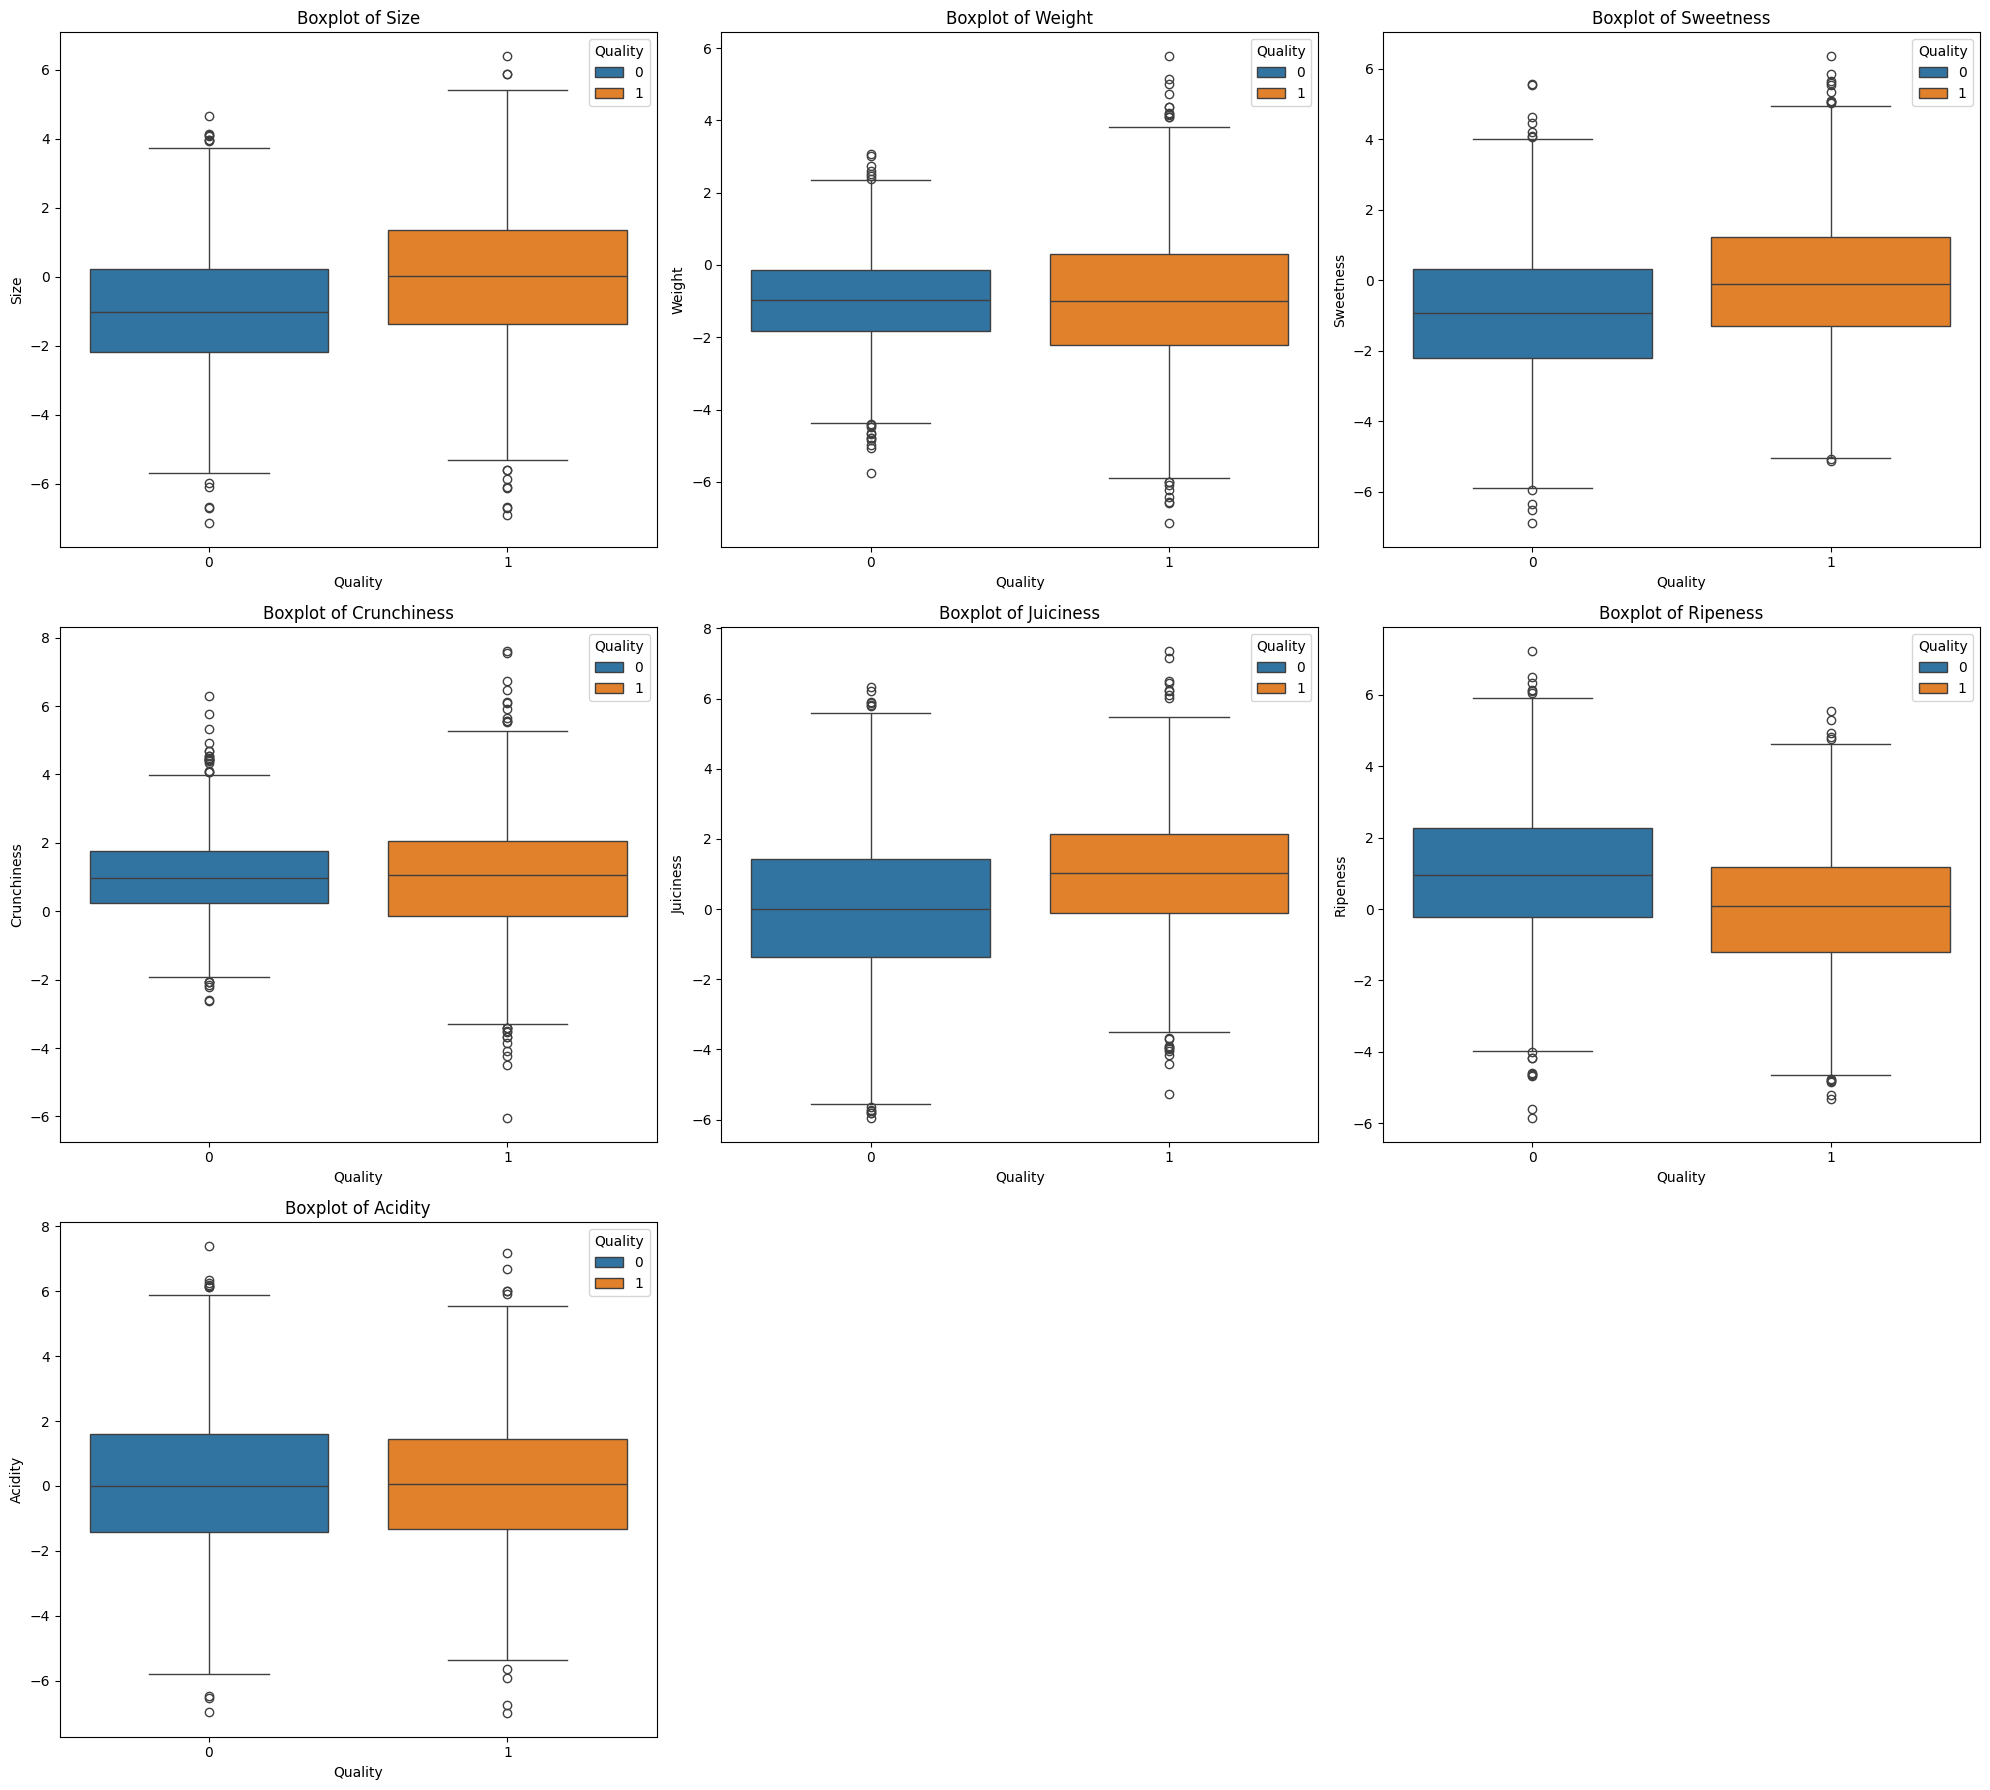

In [20]:
plt.figure(figsize=(20,18))
for i,column in enumerate(df.columns[:-1]):
    plt.subplot(3,3,i+1)
    sns.boxplot(x='Quality',y=column,data=df, hue='Quality')
    plt.title(f"Boxplot of {column}")
plt.tight_layout()

### IQR

The Interquartile Range (IQR) is a statistical measure that provides a measure of the spread or dispersion of a set of data points. It is defined as the range between the first quartile (Q1) and the third quartile (Q3) in a dataset. To find the boundaries for identifying potential outliers based on the IQR, a common rule of thumb is to consider values outside the range [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR].

In [129]:
df_iqr = pd.DataFrame(columns = ['Column', 'Q1','Q3','Outliers'])

for col in df.columns:
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    mask = (df[col] > 1.5* q3) | (df[col] < 1.5 * q1)
    iqr_series = pd.Series({'Column':col, 'Q1': q1, 'Q3':q3,'Outliers':df[col][mask].size})
    df_iqr = pd.concat([df_iqr, iqr_series.to_frame().T])
df_iqr.index = df_iqr.Column
df_iqr.drop('Column',axis=1, inplace=True)
df_iqr

Q1        Q3 Outliers
Column                                  
Size        -1.816765  0.805526     1264
Weight       -2.01177  0.030976     1394
Sweetness   -1.738425  0.801922     1289
Crunchiness  0.062764  1.894234     1366
Juiciness   -0.801286  1.835976     1237
Ripeness    -0.771677  1.766212     1284
Acidity     -1.377424  1.510493     1266
Quality           0.0       1.0        0

## Stationary of the data

In [130]:
#Execute an AdFuller test on the data. If the p-value is less than <=0.05 the data is stationary, otherwise it is not.
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  if adf_test[1] <= 0.05:
    return True
  return False
#Execute a KPSS test on the data passed by the argument. If the p-value is less than 0.05 then null hypothesis cannot be rejected
# and that's means the data is not trend stationary, otherwise is trend stationary.
def kpss_test(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  if kpss_out[1] <= 0.05:
    return False
  return True

In [131]:
adfuller_test(df.Size)
kpss_test(df.Size)
df_stationary_results =  pd.DataFrame(columns=['Feature','KPSS','ADF'])
for column in df.columns:
    stationary_column_res_series = pd.Series({'Feature':column,'KPSS': kpss_test(df[column]), 'ADF':adfuller_test(df[column])})
    df_stationary_results = pd.concat([df_stationary_results, stationary_column_res_series.to_frame().T])

df_stationary_results.index = df_stationary_results.Feature
df_stationary_results.drop(['Feature'], inplace=True, axis=1)

In [132]:
df_stationary_results

KPSS   ADF
Feature                
Size         True  True
Weight       True  True
Sweetness    True  True
Crunchiness  True  True
Juiciness    True  True
Ripeness     True  True
Acidity      True  True
Quality      True  True

This is a really good sign because all the features are stationary and this means that shifting  by some fixed amount gives the same probabilistic description of the random variables. In practical terms the distribution stay the same after a displacement.

## Distribution

### Proportion of good and bad apples

Text(0.5, 1.0, 'Quality')

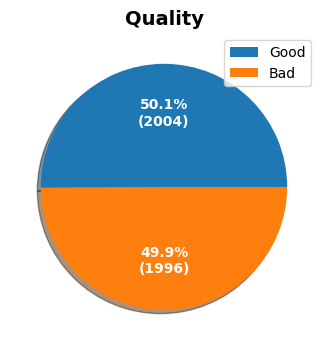

In [133]:
df_quality = df['Quality'].value_counts().to_frame()
labels = ['Good','Bad']
values = df_quality.iloc[:,0].to_list()

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"

fig,ax = plt.subplots(figsize = (4,4))
ax.pie(x = values, labels = labels, autopct=autopct_fun(values), shadow = True, textprops = {'color':'white', 'fontsize':10, 'fontweight':'bold'})
ax.legend(labels)
ax.set_title("Quality", fontsize = 14, fontweight = "bold", color = "black")

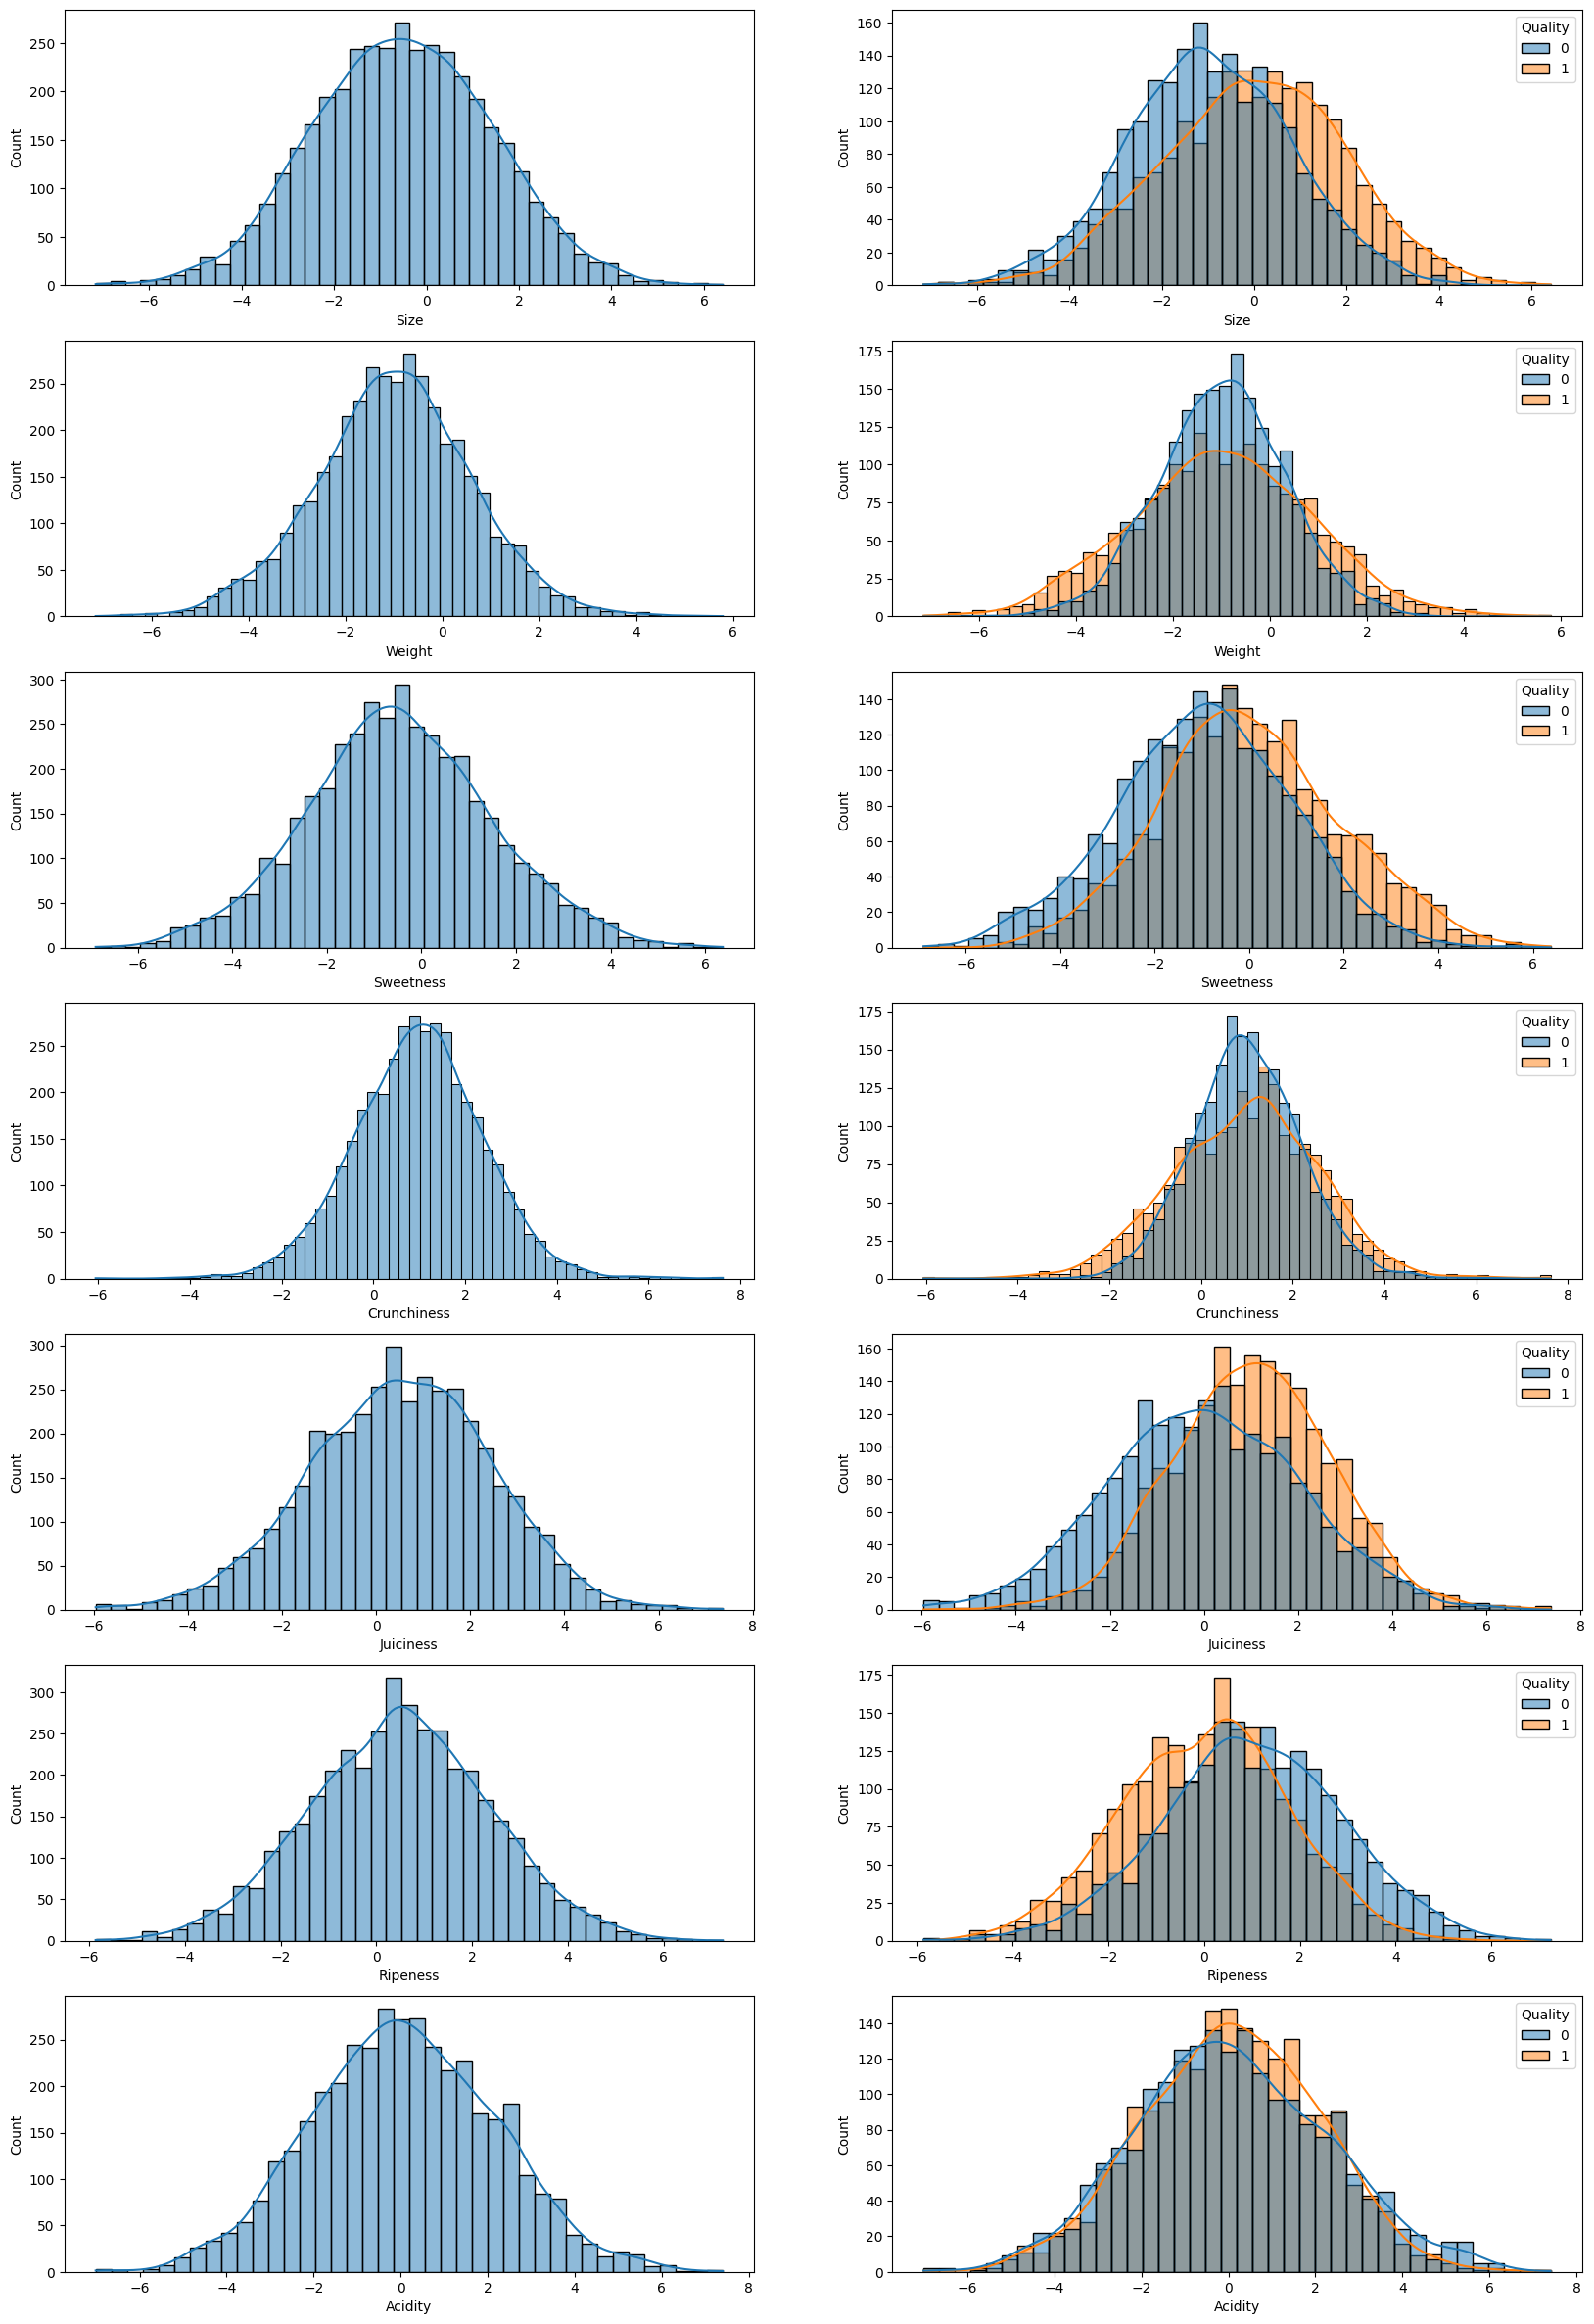

In [26]:
fig, axes = plt.subplots(7,2, figsize=(20,30))
for i in range(7):
    sns.histplot(data=df, x=df.columns[i], ax=axes[i][0], kde=True)
    sns.histplot(data=df, x=df.columns[i], ax=axes[i][1], hue='Quality', kde=True)

To the left can be seen the distribution of the single feature, to the right we can see the distribution for the values with quality equals to 1 and equals to 0.
With and without considering the quality parameter, it's possible to see that the data is somewhat following a normal distribution.

# Statistical Tests

## Normal Distribution

We've seen from above that the distributions of the features seems to follow a normal distribution, this part will try to test statistically and visually if the distribution is a normal one. It is an important to step to decide which type of models we can use, if the data is following a Normal Distribution then we can think of using the Gaussian Naive Bayes Model for the modeling part, or if the data is following another type of distribution then we can think of different models.

In [134]:
normal_res_df = pd.DataFrame(columns=['Name','Normal_Test','Shapiro'])

for col in df.columns:
    statistic_normal, p_value_normal_test = stats.normaltest(df[col])
    stat_shapiro, p_value_shapiro = stats.shapiro(df[col])
    anderson_test = stats.anderson(df[col])
    sig_res = anderson_test.significance_level[anderson_test.statistic < anderson_test.critical_values]
    res_series = pd.Series({'Name':col, 'Normal_Test': p_value_normal_test > 0.05, 'Shapiro': p_value_shapiro > 0.05,'Anderson': len(sig_res) > 0})

    normal_res_df = pd.concat([normal_res_df, res_series.to_frame().T])
normal_res_df.index = normal_res_df.Name
normal_res_df.drop('Name',inplace=True,axis=1)

In [135]:
display(normal_res_df)

Normal_Test Shapiro Anderson
Name                                    
Size               True    True     True
Weight            False   False    False
Sweetness          True   False    False
Crunchiness       False   False    False
Juiciness         False   False     True
Ripeness           True    True     True
Acidity            True    True     True
Quality           False   False    False

All these statistical tests gives us different result regarding the normal distribution of our features, because the normal test gives us 4 features which follows a Normal test, the Shapiro test 3 and the Anderson 4. We can say for sure that Size, Ripeness and Acidity follow a normal distribution. Another way to figure out if the features follows a normal distribution is the Q-Q plot.

### Q-Q Plot

A Quantile-Quantile (Q-Q) plot is a graphical tool used to assess whether a given dataset follows a particular theoretical distribution, such as the normal distribution.
* Linearity:
    * Straight Line: If the points on the Q-Q plot fall approximately along a straight line, it suggests that the data follows the theoretical distribution being tested (e.g., normal distribution).
    * Curvature or Deviation: If the points deviate from a straight line, especially towards the tails, it indicates a departure from the assumed distribution.
* Symmetry:
    * Symmetric Distribution: If the points are symmetrically distributed around the diagonal line (y=x), it suggests that the data is symmetrically distributed.
    * Skewness or Asymmetry: Asymmetry in the plot may indicate skewness in the data.
* Outliers:
    * Outliers Away from the Line: Outliers that are far from the diagonal line may suggest extreme values or heavy tails not captured by the assumed distribution.
* Tails:
    * Curvature in Tails: Curvature in the tails of the Q-Q plot indicates differences between the sample distribution and the theoretical distribution in those regions.
* Compare with Reference Line:
    * Perfect Fit: If the points fall perfectly along the diagonal line, it indicates a perfect fit to the assumed distribution.
    * Departure from Line: Any departure from the diagonal line suggests a departure from the assumed distribution.

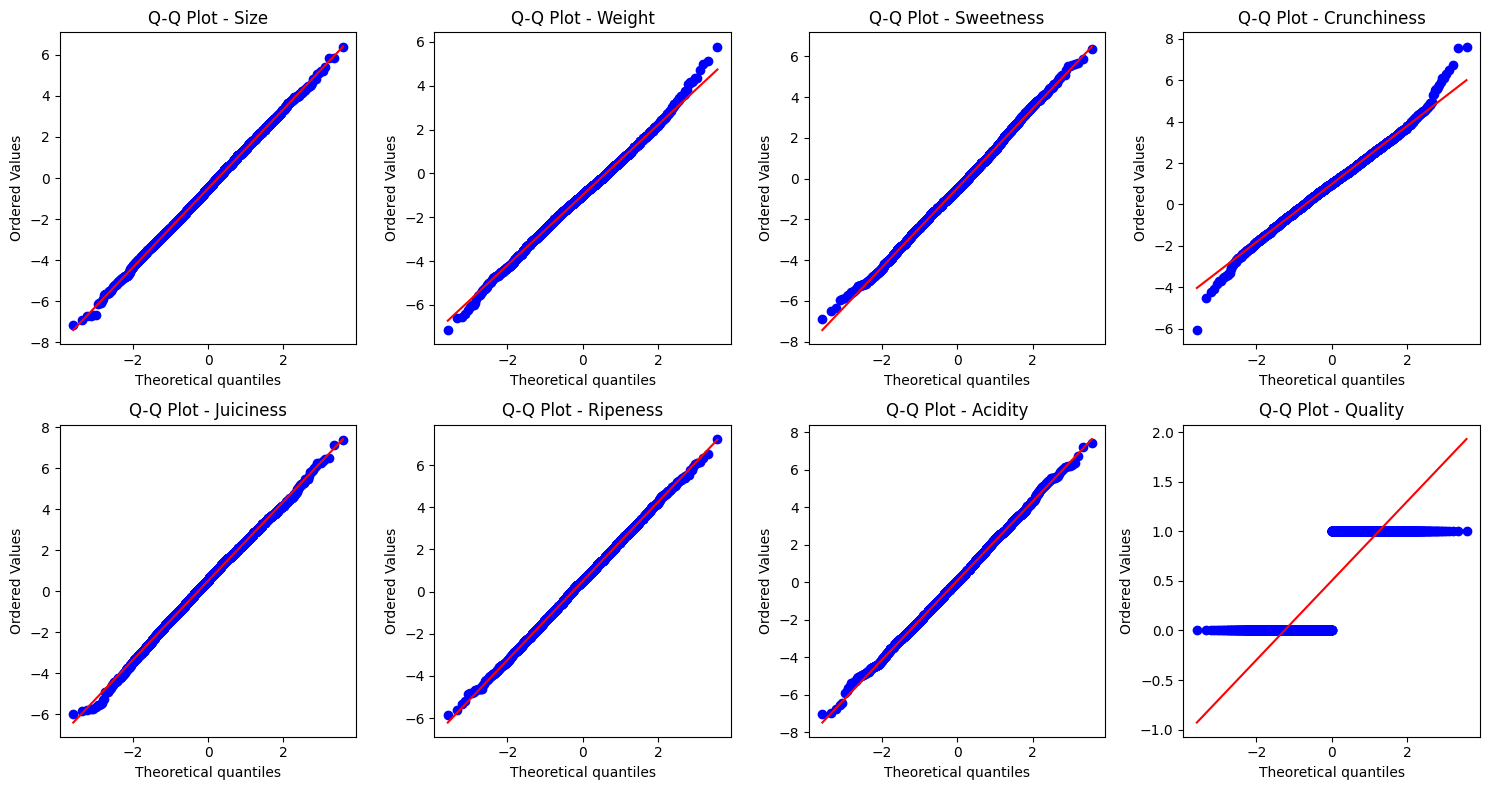

In [29]:
num_rows, num_cols = 2, 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Iterate through each column and create Q-Q plots
for i, column in enumerate(df.columns):
    stats.probplot(df[column], dist='norm', plot=axes[i])
    axes[i].set_title(f'Q-Q Plot - {column}')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

The data seems following the red line in all the plots except for the last one which we are not interested because it's a binomial.The Crunchiness and the Juiciness are the ones who have most curvature in the tails. 

## Independence of the features

Why is it important to have indepenence of the features:
* Improved Model Accuracy: When features are independent, they provide unique information to the model. This reduces redundancy and helps the model capture the true relationships between features and the target variable, leading to more accurate predictions.
* Reduced Overfitting: Independent features are less likely to be correlated with each other, which lowers the risk of the model overfitting to noise in the data. This translates to better generalizability to unseen data.
* Enhanced Interpretability: If features are independent, their individual contribution to the model's predictions becomes clearer. This allows for better understanding of the model's decision-making process and provides valuable insights into the problem being studied.


### Visual test

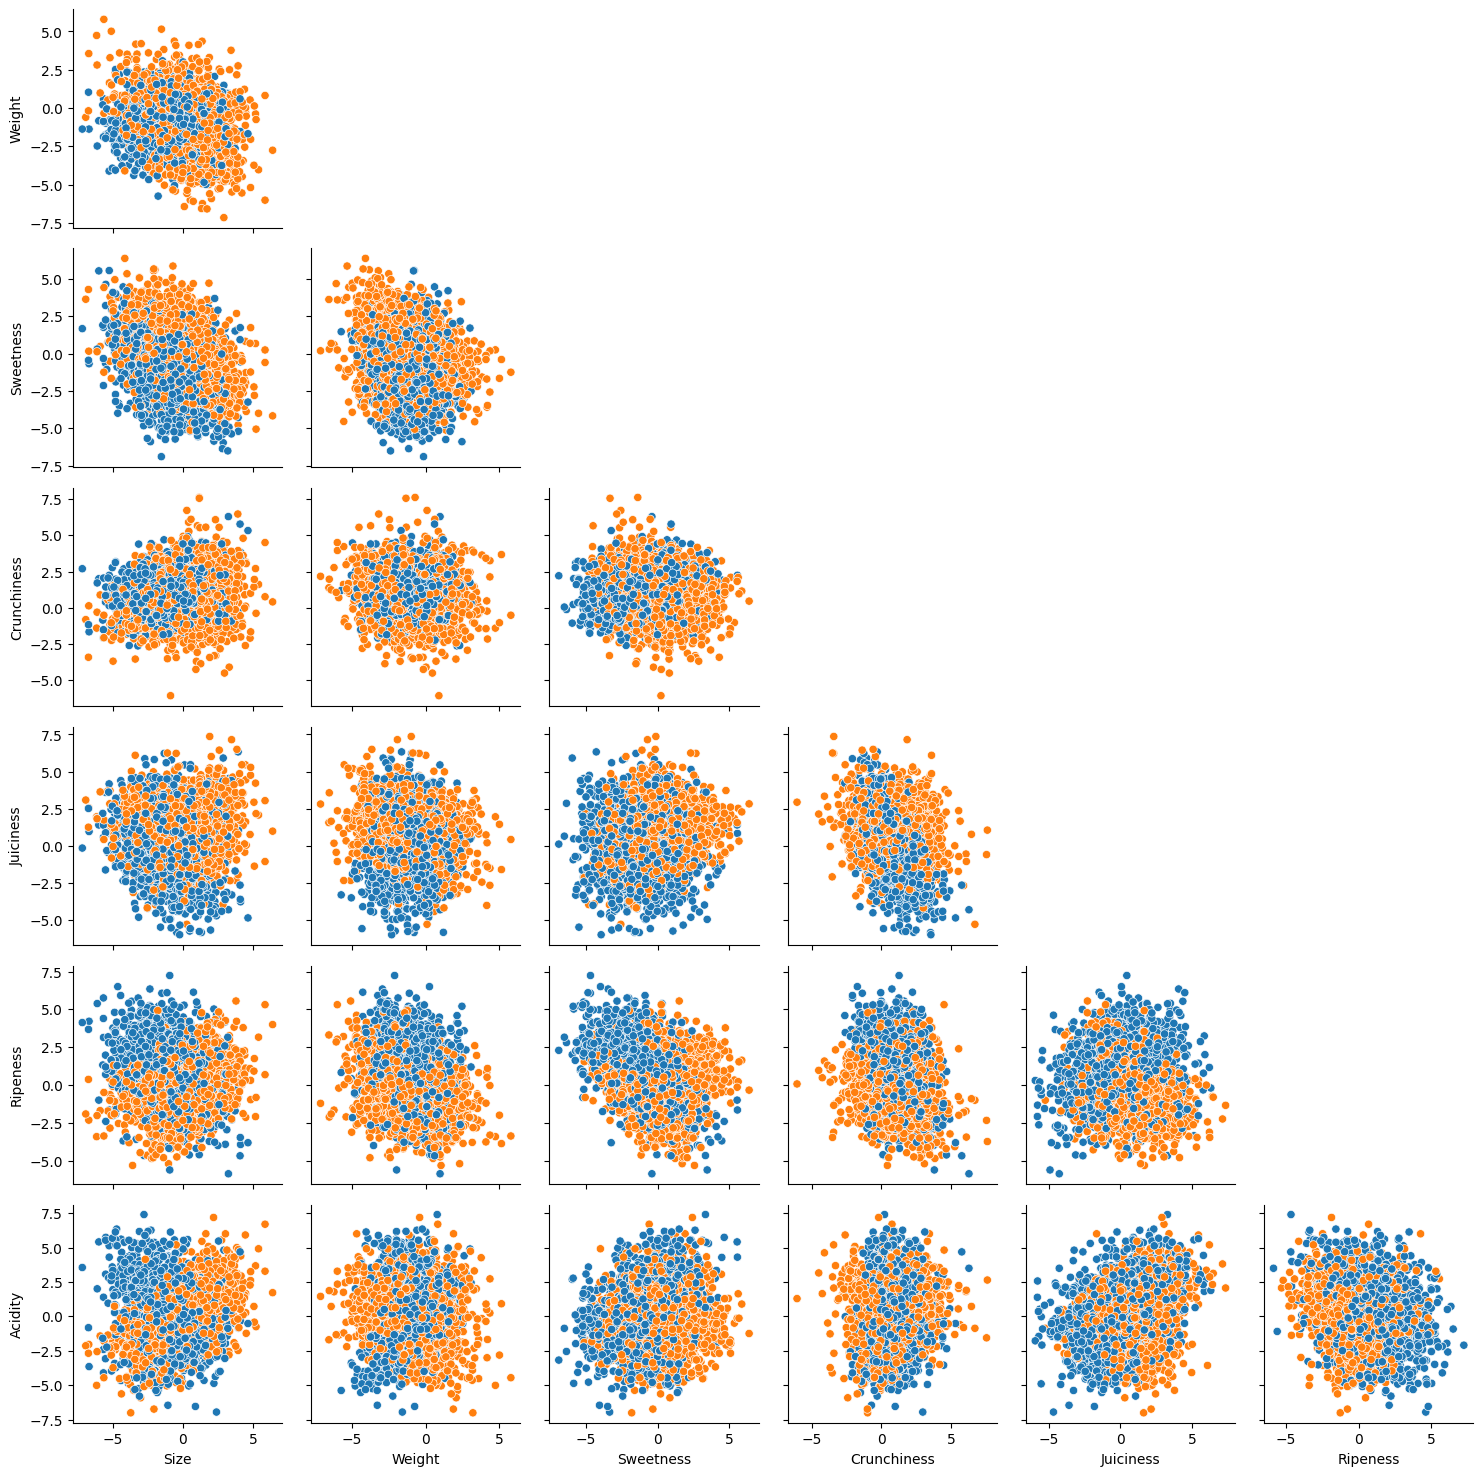

In [30]:
pair_grid = sns.PairGrid(df,corner=True,diag_sharey=False, hue='Quality')
pair_grid.map_lower(sns.scatterplot, color='blue')
#Remove the diagonal plots
for i in range(pair_grid.axes.shape[0]):
    for j in range(pair_grid.axes.shape[1]):
        if i == j:
            pair_grid.axes[i, j].remove()

### Correlation

According to the graph shown we can see that no pair of variables presents a correlation, we are going to create the correlation matrix, according to the result of the normal distribution from all perspectives (visually and statistically) it seems that the majority of the features is following a normal distribution. Given the fact that from the plots there does not seem to be a linear relationship, the choice for the correlation method is the Sperman.

* Use Pearson:
    * For continuous, interval-scaled data
    * When interested in the strength and direction of a linear relationship
    * When data is approximately normally distributed
* Use Spearman:
    * For ordinal data (rankings, Likert scales)
    * When data is not normally distributed
    * When only interested in the direction of the relationship, not necessarily the strength

<Axes: >

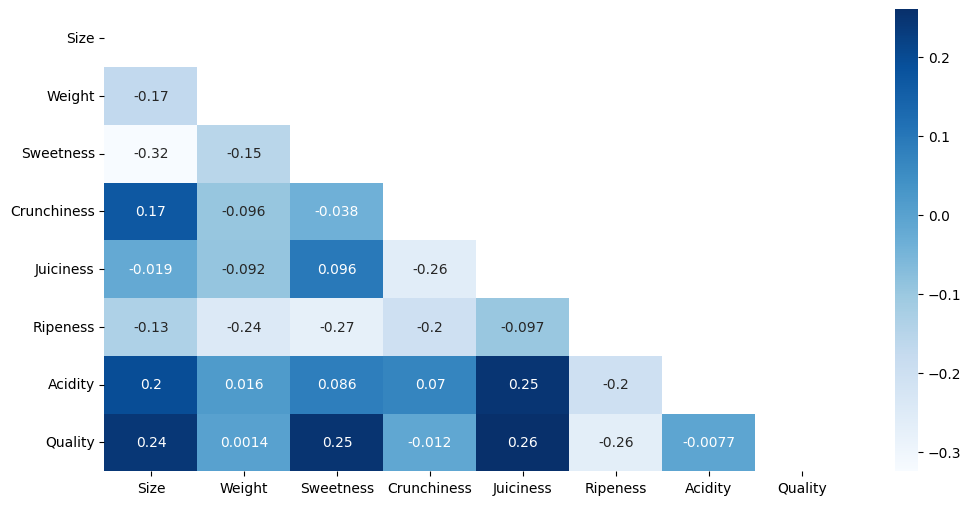

In [31]:
correlation_matrix_df = df.corr(method='pearson')
fig = plt.figure(figsize=(12,6))
mask = np.triu(np.ones_like(correlation_matrix_df, dtype=bool))
sns.heatmap(correlation_matrix_df,annot=True,cmap='Blues', mask = mask)

<Axes: >

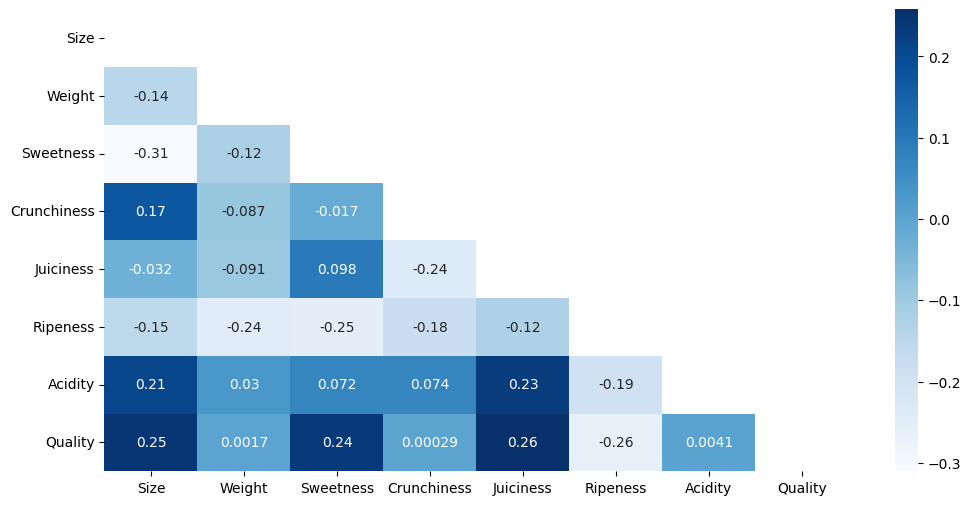

In [32]:
correlation_matrix_df = df.corr(method='spearman')
fig = plt.figure(figsize=(12,6))
mask = np.triu(np.ones_like(correlation_matrix_df, dtype=bool))
sns.heatmap(correlation_matrix_df,annot=True,cmap='Blues', mask = mask)

They give moreover the same results, there does not seem to be strong correlation between the features.

### Correlation Distance

Another type of test is done by seeing the distance correlation which measures the dependence between two sets of features, regardless of their distribution and without assuming linearity. Unlike Pearson's correlation, which is limited to linear relationships, distance correlation can detect both linear and non-linear relationships between variables

In [33]:
from hyppo.independence import Dcorr
import math
dcorr = Dcorr()
# Assuming df is your DataFrame with numerical features
cols = [column for column in df.columns if column != 'Quality']
num_rows = len(cols)
for i in range(num_rows):
    for j in range(i+1, num_rows):
            stat,_ = dcorr.test(df[cols[i]].values, df[cols[j]].values)
            print(f"[{cols[i]}, {cols[j]}]",stat)

[Size, Weight] 0.020177206950486387
[Size, Sweetness] 0.08510322837721489
[Size, Crunchiness] 0.03127043074973708
[Size, Juiciness] 0.008682617664582119
[Size, Ripeness] 0.024535561069435857
[Size, Acidity] 0.04803597999879566
[Weight, Sweetness] 0.019150780028428467
[Weight, Crunchiness] 0.007475492357510503
[Weight, Juiciness] 0.009155993297928154
[Weight, Ripeness] 0.0539154326329786
[Weight, Acidity] 0.0021577298836780324
[Sweetness, Crunchiness] 0.0015443328547240403
[Sweetness, Juiciness] 0.009887972398875022
[Sweetness, Ripeness] 0.06853423186466334
[Sweetness, Acidity] 0.011688657293303479
[Crunchiness, Juiciness] 0.0504056841485978
[Crunchiness, Ripeness] 0.032947139481567266
[Crunchiness, Acidity] 0.011250429216358122
[Juiciness, Ripeness] 0.02098122503653179
[Juiciness, Acidity] 0.053057577045028774
[Ripeness, Acidity] 0.03964038826318731


Those are low number, so we can assume that there is no dependence between the features, this tests basically just confirmed what we've known before.

# Machine Learning

The aim of this part is to classify whether an apple has a good or bad quality. The columns are divided in two parts: the predictors and the predicted value. The predictor columns are composed of 7 features: Size, Weight, Acidity, Ripeness, Sweetness, Juiciness and Crunchiness, the value we want to predict is the Quality. We'll start with a Tree decision Classifier then moving to a SVC and lastly to a Neural network. Lastly we will compare the different models and see which is the best one.

## Import of the libraries

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Prepare the data

In [136]:
X = df.drop('Quality',axis=1).values
y = df['Quality'].values
print(X.shape)
print(y.shape)

(4000, 7)
(4000,)


### Divide the dataset into train and test set

In [137]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#### Create the standardized data 

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Model evaluation Class

In [144]:
class Model:
    def __init__(self, model,name=None, scaled=False):
        self.model = model
        self.name = name
        self.scaled = scaled
    def fit(self):
        if self.scaled:
            self.model.fit(X_train_scaled, y_train)
        else:
            self.model.fit(X_train, y_train)
    def __get_predictions(self):
        if self.scaled:
            return self.model.predict(X_test_scaled), self.model.predict_proba(X_test_scaled)[:,1]
        else:
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        
    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series
    
    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.axis('equal')
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

* $Recall = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$
    * In words, recall answers the question: "Out of all the actual positive instances, how many did the model correctly identify?" It is particularly important in situations where the cost of missing positive instances (false negatives) is high, and you want to minimize the chances of false negatives.


* $Precision = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}$ 
    * In words, precision answers the question: "Out of all the instances predicted as positive by the model, how many were actually positive?" It is particularly important in situations where the cost of false positives (instances predicted as positive but are actually negative) is high, and you want to minimize the chances of making false positive predictions.
* $Accuracy = \frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}}$
* $F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} \times \text{Recall}}$
    * In words, the F1 score provides a balance between precision and recall. It ranges from 0 to 1, where 1 indicates perfect precision and recall, and 0 indicates poor performance

In [142]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
            'Precision',
            'Recall',
            'F1-Score',
            'ROC AUC',
            'Confusion Matrix',
            'PR AUC'])

## Linear Discriminant Analysis

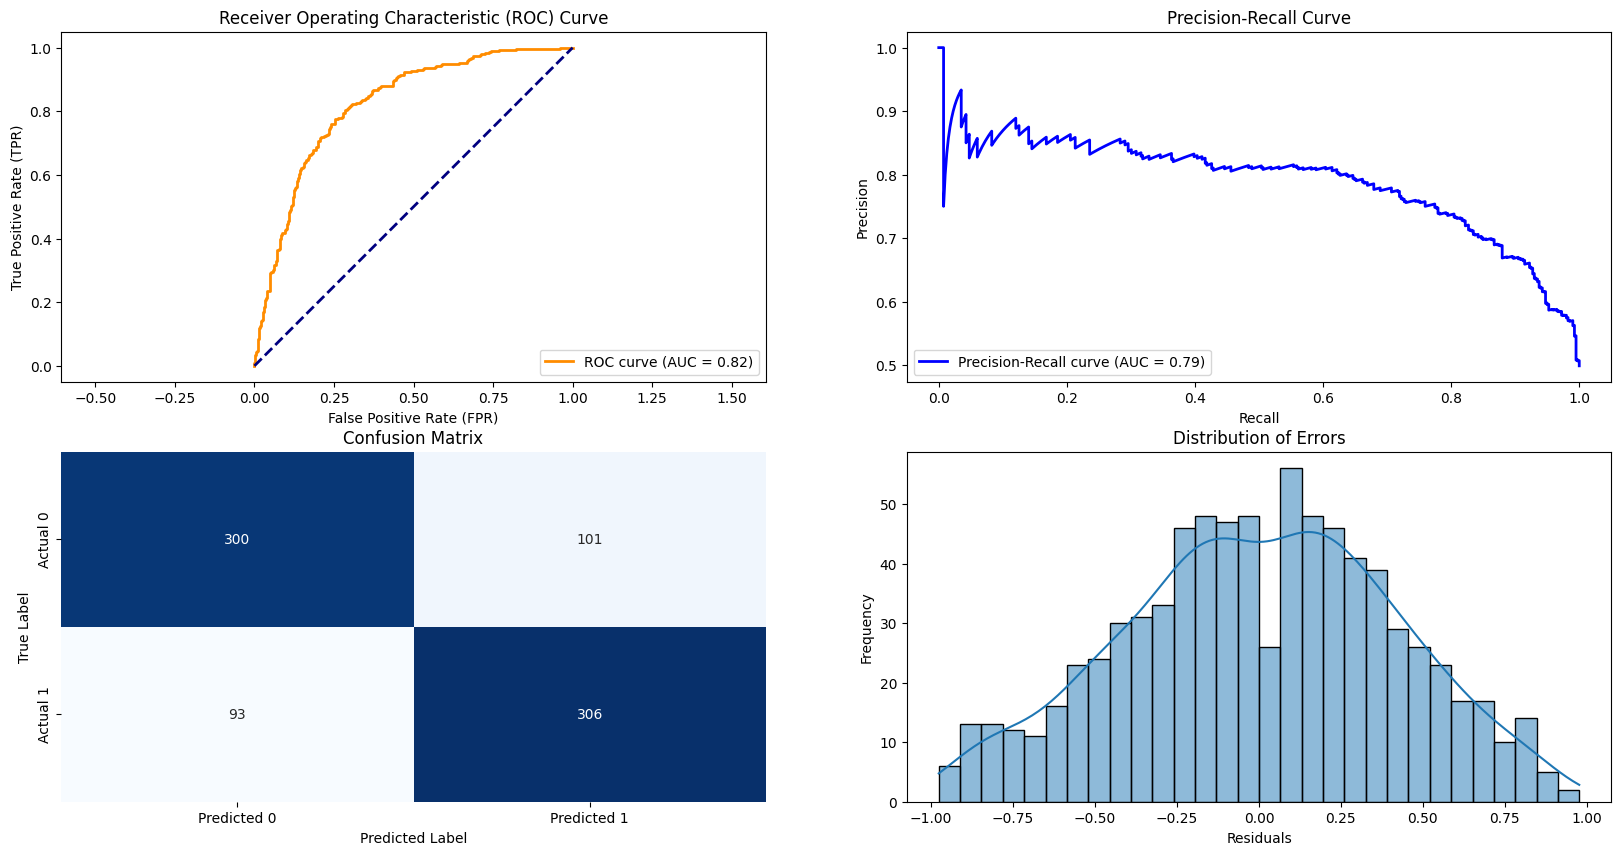

In [145]:
model = Model(LinearDiscriminantAnalysis())
model.fit()
model.visualize_metrics()

In [146]:
metrics_LDA = model.get_metrics()
models_df = pd.concat([models_df, metrics_LDA.to_frame().T])
print(metrics_LDA)

Accuracy                                0.7575
Precision                             0.751843
Recall                                0.766917
F1-Score                              0.759305
ROC AUC                               0.822668
Confusion Matrix       [[300, 101], [93, 306]]
PR AUC                                0.790227
Name                LinearDiscriminantAnalysis
dtype: object


## Naive Bayes (Gaussian)

Naive Bayes is a family of probabilistic algorithms based on Bayes' theorem, which is a fundamental theorem in probability theory. It's based on:
* Bayes' Theorem which calculates the probability of a hypothesis given the observed evidence.
* Independence Assumption: features must be independent from each other

There are a lot of different Naive Bayes algorithms which are based on the distribution of the data. Recalling the fact that 4 of the features follows a normal distribution and from previous calculation we've determined that there is not a lot of dependency between the features so I've decided to use the Gaussian NB algorithm

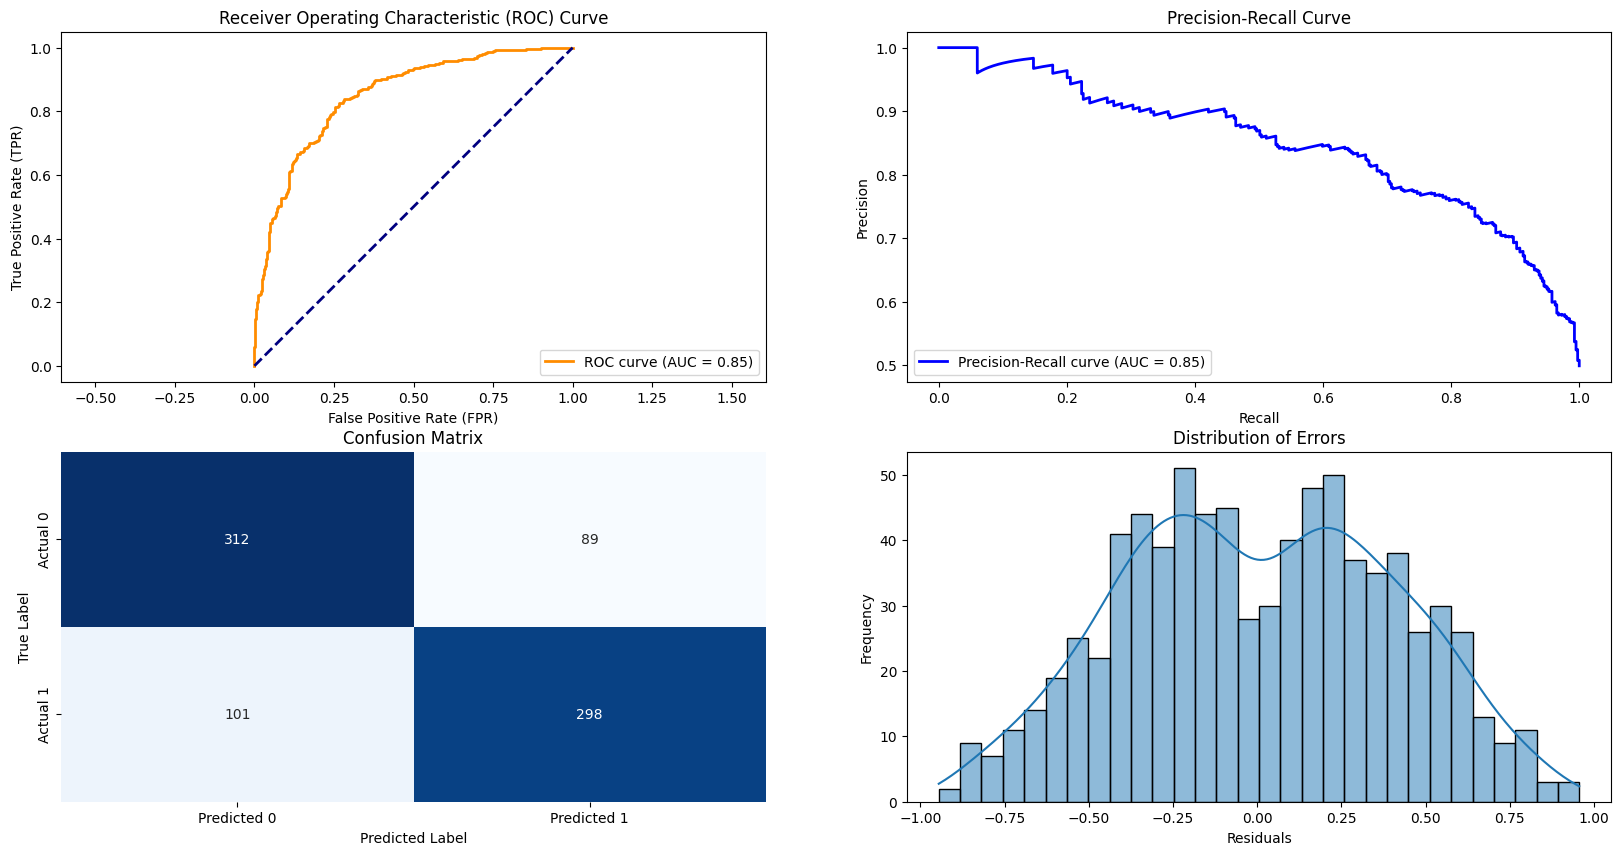

In [147]:
model = Model(GaussianNB(), name='Gaussian Naive Bayes')
model.fit()
model.visualize_metrics()

In [148]:
metrics_NB = model.get_metrics()
models_df = pd.concat([models_df, metrics_NB.to_frame().T])
print(metrics_NB)

Accuracy                             0.7625
Precision                          0.770026
Recall                             0.746867
F1-Score                            0.75827
ROC AUC                            0.850899
Confusion Matrix    [[312, 89], [101, 298]]
PR AUC                             0.846821
Name                   Gaussian Naive Bayes
dtype: object


### Bernoulli Naive Bayes

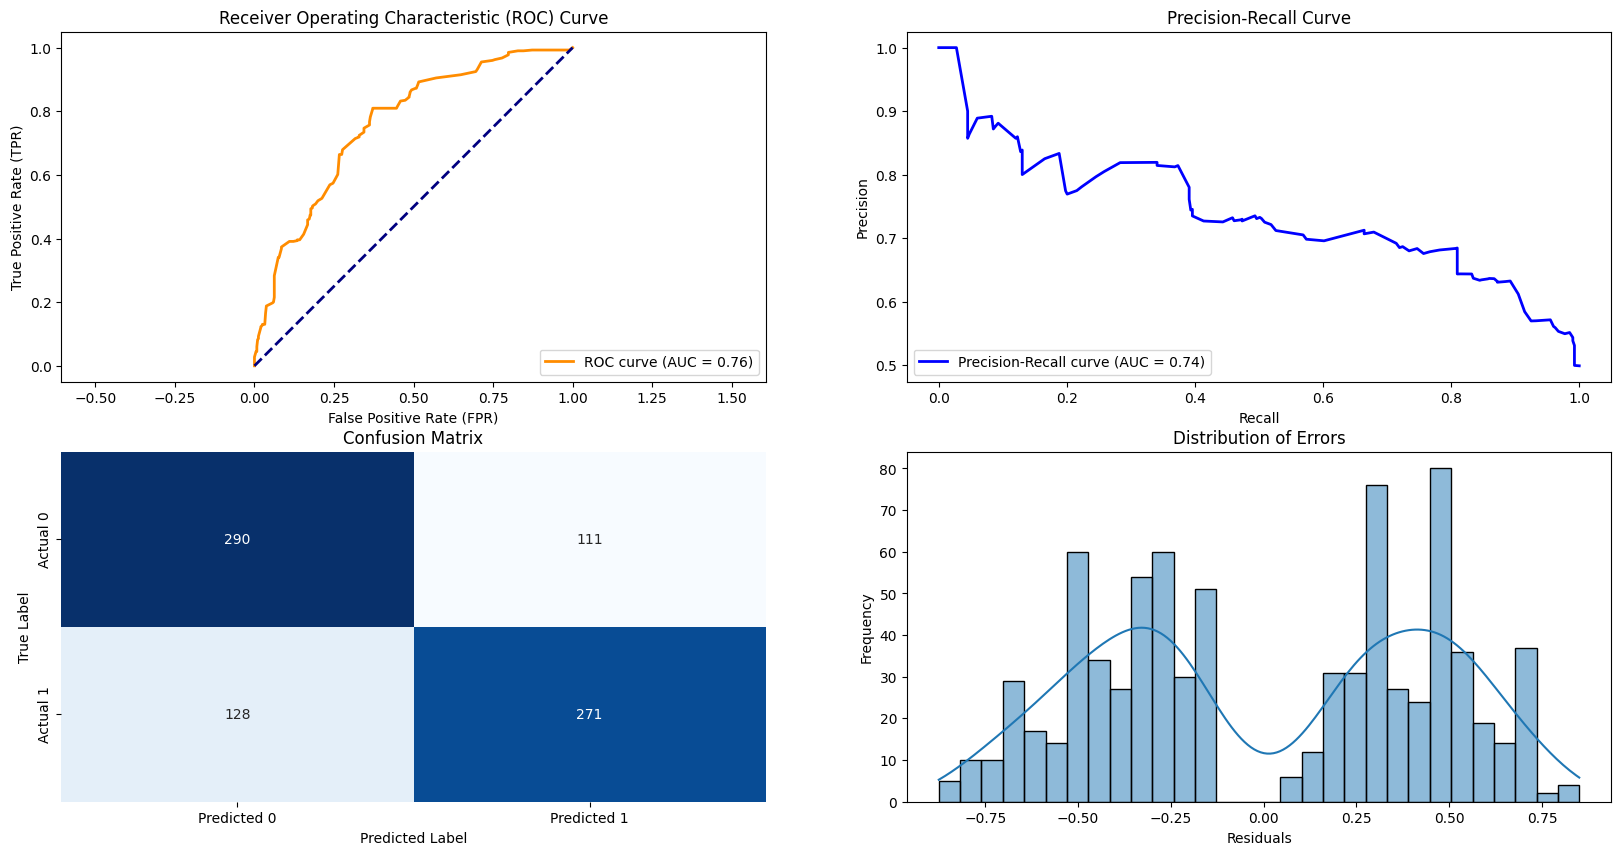

In [149]:
model = Model(BernoulliNB(),'Bernoulli Naive Bayes')
model.fit()
model.visualize_metrics()

In [150]:
metrics_BNB = model.get_metrics()
models_df = pd.concat([models_df, metrics_BNB.to_frame().T])
print(metrics_BNB)

Accuracy                             0.70125
Precision                           0.709424
Recall                              0.679198
F1-Score                            0.693982
ROC AUC                             0.759252
Confusion Matrix    [[290, 111], [128, 271]]
PR AUC                              0.737735
Name                   Bernoulli Naive Bayes
dtype: object


## Logistic Regression

Logistic regression is a statistical method used for binary classification, which means predicting the probability that an instance belongs to one of two classes. Despite its name, logistic regression is primarily employed for classification tasks rather than regression.

In logistic regression, the logistic function, also known as the sigmoid function, is used to model the relationship between the independent variables and the probability of the dependent variable belonging to a particular class. The output of the logistic regression model is a probability score between 0 and 1, and a threshold is typically applied to classify instances into one of the two classes.

The logistic regression model assumes a linear relationship between the independent variables and the log-odds of the probability of the dependent variable. The model is trained by adjusting the weights of the independent variables through an optimization process, often using techniques like maximum likelihood estimation.

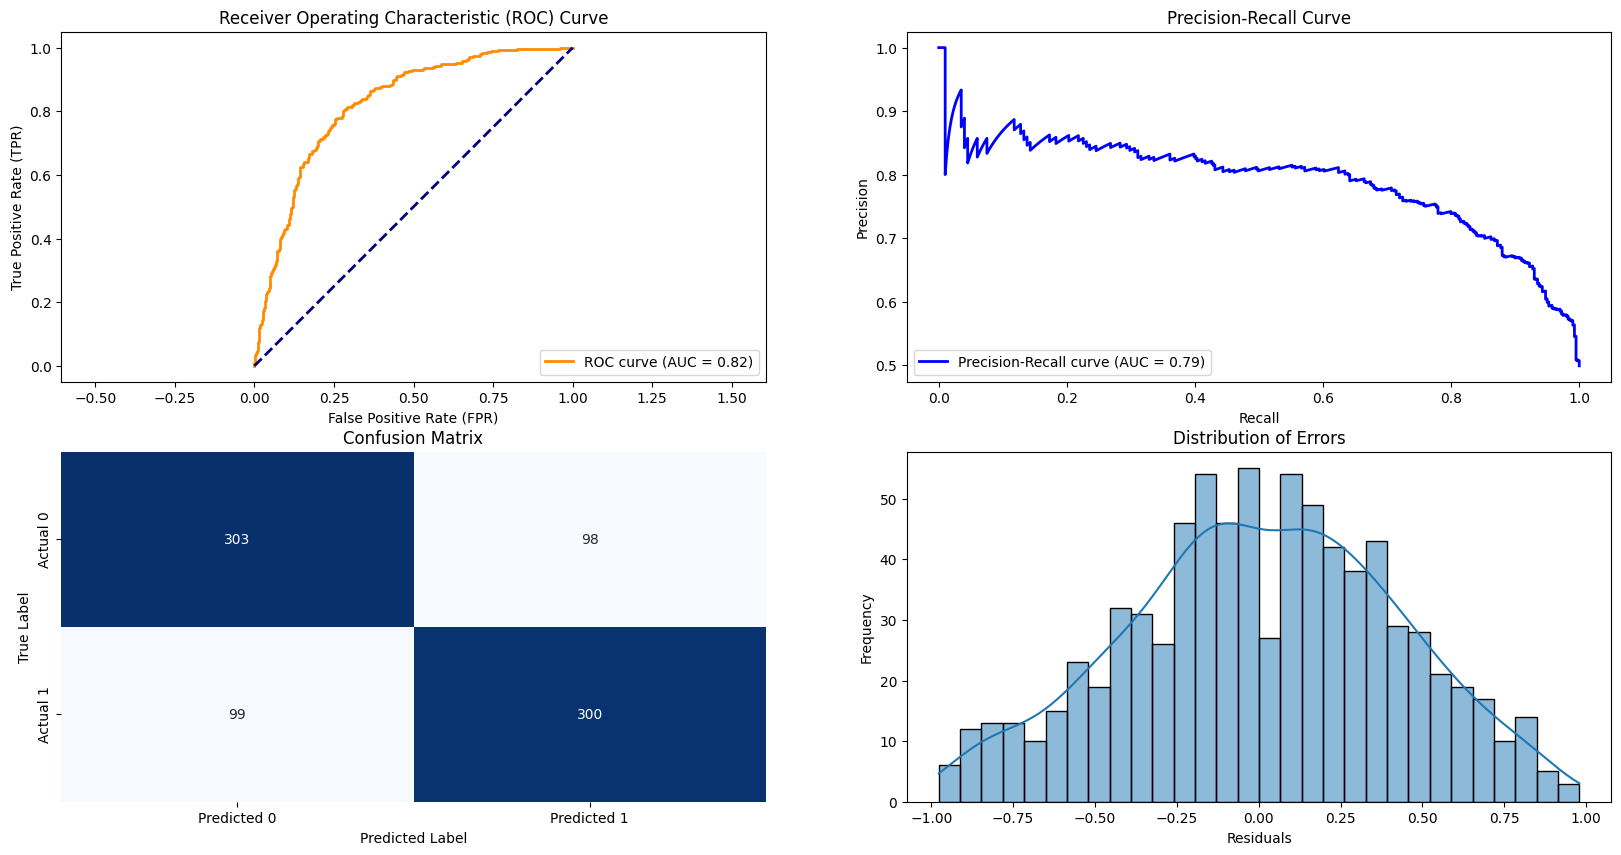

In [151]:
# Create the model
model = Model(LogisticRegression(), name='Logistic Regression')
model.fit()
model.visualize_metrics()

In [152]:
metrics_LR = model.get_metrics()
models_df = pd.concat([models_df, metrics_LR.to_frame().T])
print(metrics_LR)

Accuracy                           0.75375
Precision                         0.753769
Recall                             0.75188
F1-Score                          0.752823
ROC AUC                            0.82313
Confusion Matrix    [[303, 98], [99, 300]]
PR AUC                            0.790266
Name                   Logistic Regression
dtype: object


### Scaled

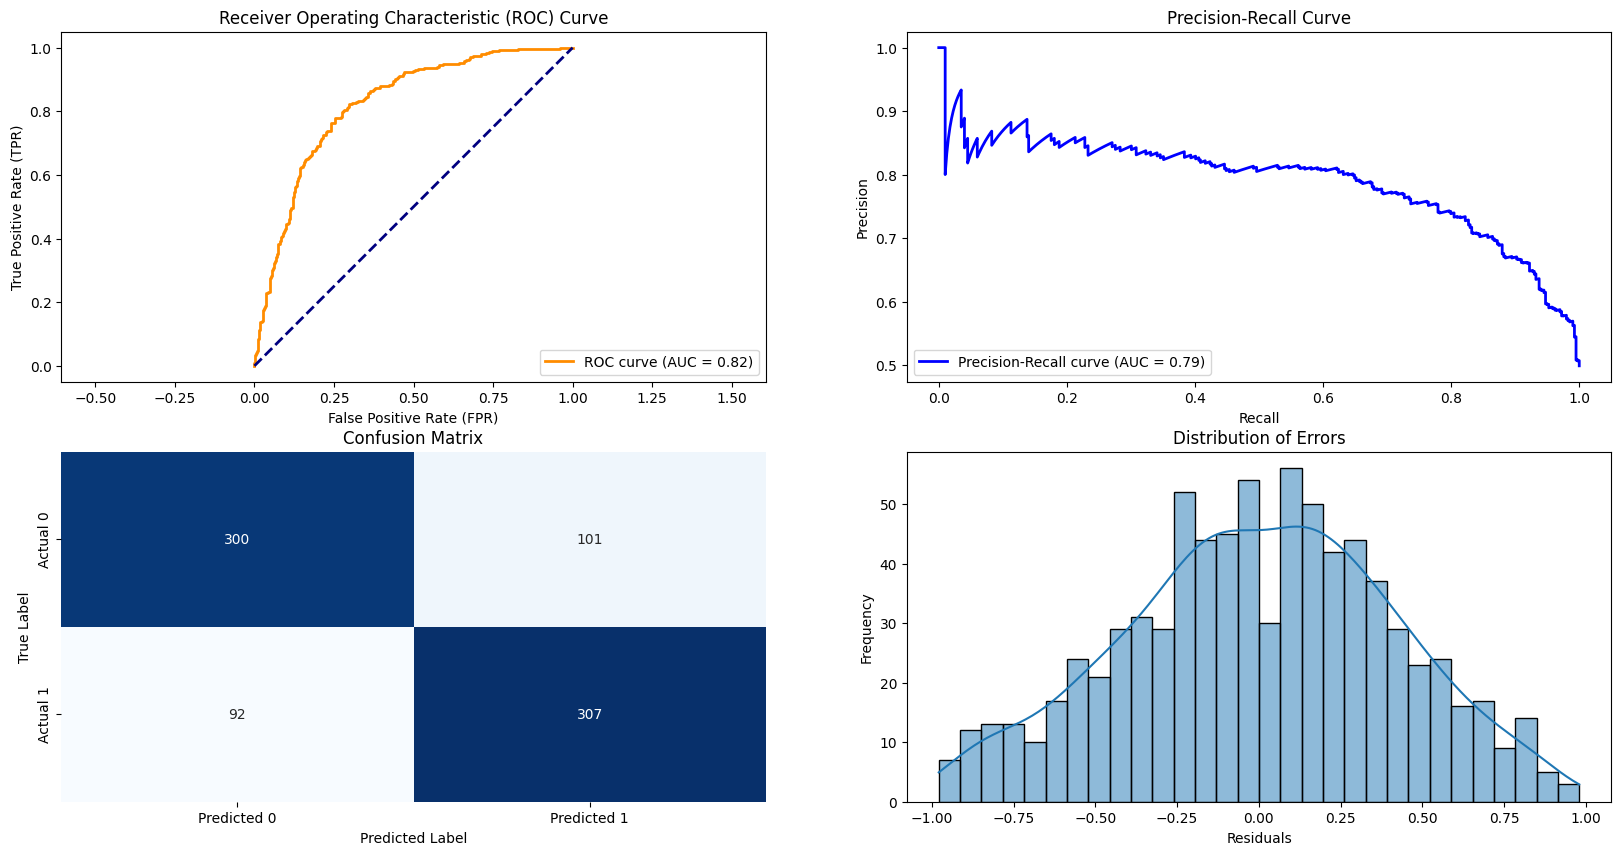

In [153]:
# Create the model
model = Model(LogisticRegression(), name='Logistic Regression Scaled', scaled=True)
model.fit()
model.visualize_metrics()

In [154]:
metrics_LR_Scaled = model.get_metrics()
models_df = pd.concat([models_df, metrics_LR_Scaled.to_frame().T])
print(metrics_LR_Scaled)

Accuracy                               0.75875
Precision                             0.752451
Recall                                0.769424
F1-Score                              0.760843
ROC AUC                               0.823249
Confusion Matrix       [[300, 101], [92, 307]]
PR AUC                                0.790764
Name                Logistic Regression Scaled
dtype: object


### Best Logistic Regression Model

In [155]:
from sklearn.model_selection import GridSearchCV

In [156]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_scaled, y_train)
print(clf.best_params_)

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
#C  =10, penalty = L2, solver = liblinear

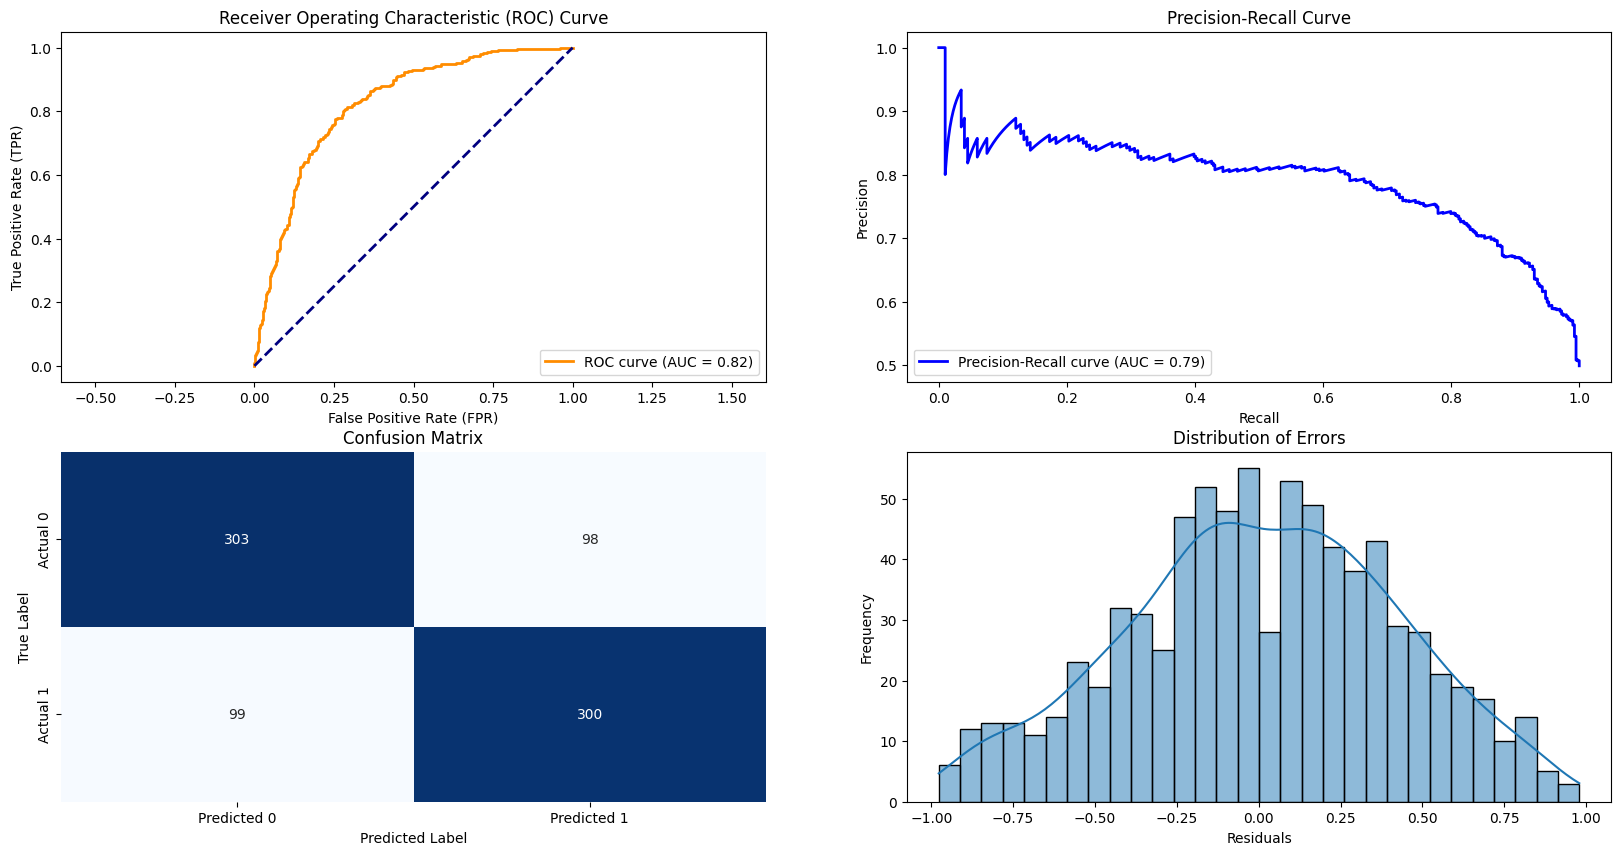

In [157]:
model = Model(LogisticRegression(C = 10, penalty='l2', solver='liblinear'), name='Grid Search Logistic Regression')
model.fit()
model.visualize_metrics()

In [158]:
metrics_LR_Best = model.get_metrics()
models_df = pd.concat([models_df, metrics_LR_Best.to_frame().T])
print(metrics_LR_Best)

Accuracy                                    0.75375
Precision                                  0.753769
Recall                                      0.75188
F1-Score                                   0.752823
ROC AUC                                    0.823149
Confusion Matrix             [[303, 98], [99, 300]]
PR AUC                                     0.790336
Name                Grid Search Logistic Regression
dtype: object


## Decision Tree Classifier

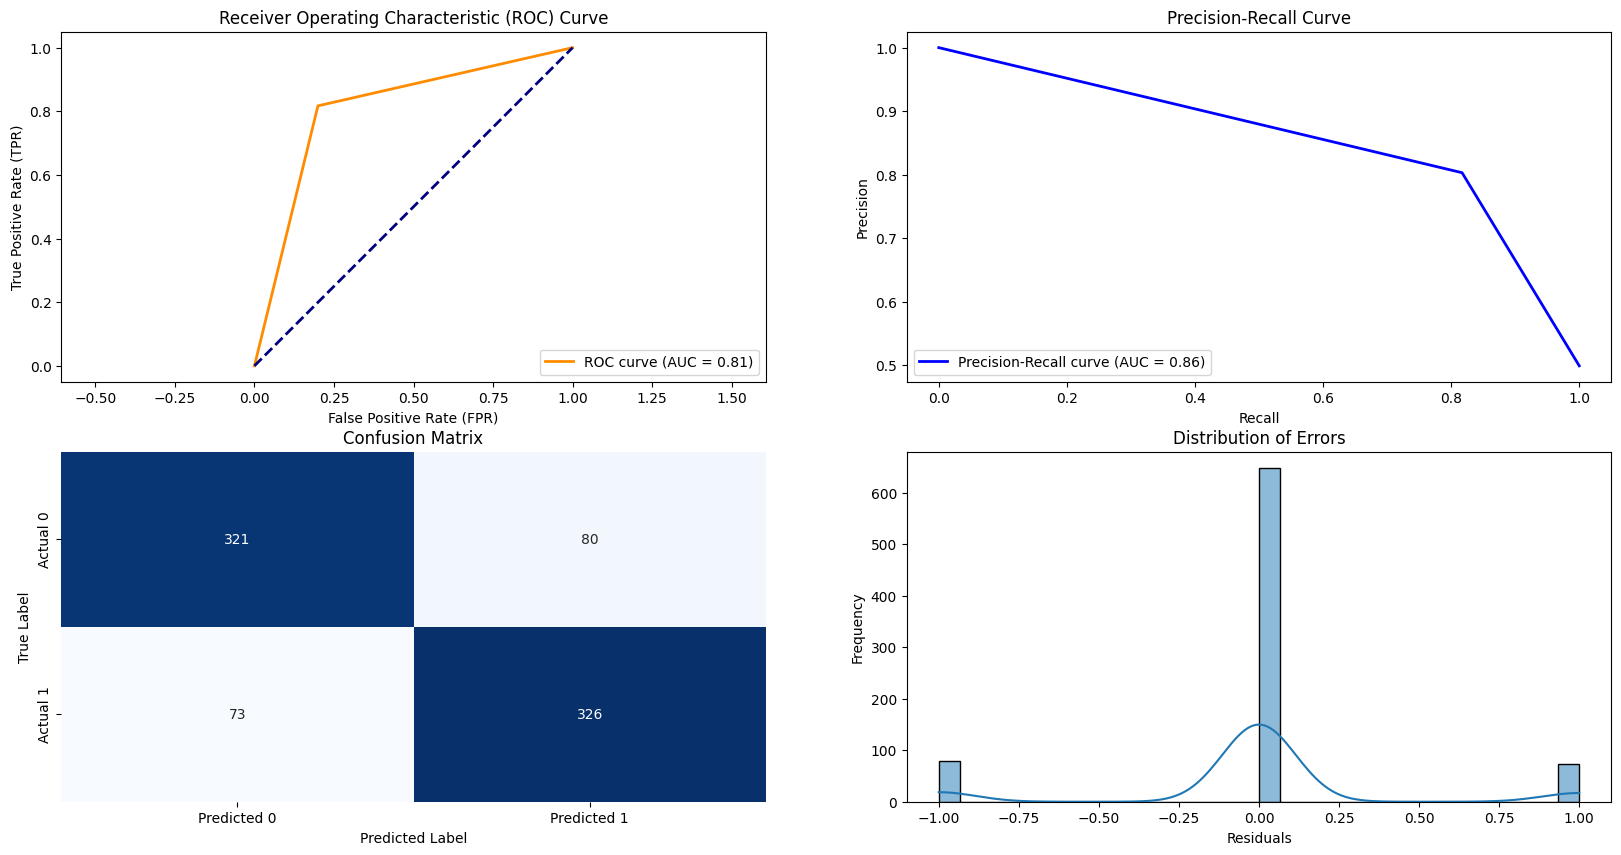

In [159]:
model = Model(DecisionTreeClassifier(), 'Decision Tree Classifier')
model.fit()
model.visualize_metrics()

In [160]:
metrics_DT = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT.to_frame().T])
print(metrics_DT)

Accuracy                             0.80875
Precision                           0.802956
Recall                              0.817043
F1-Score                            0.809938
ROC AUC                             0.808771
Confusion Matrix      [[321, 80], [73, 326]]
PR AUC                              0.747299
Name                Decision Tree Classifier
dtype: object


## Scaled

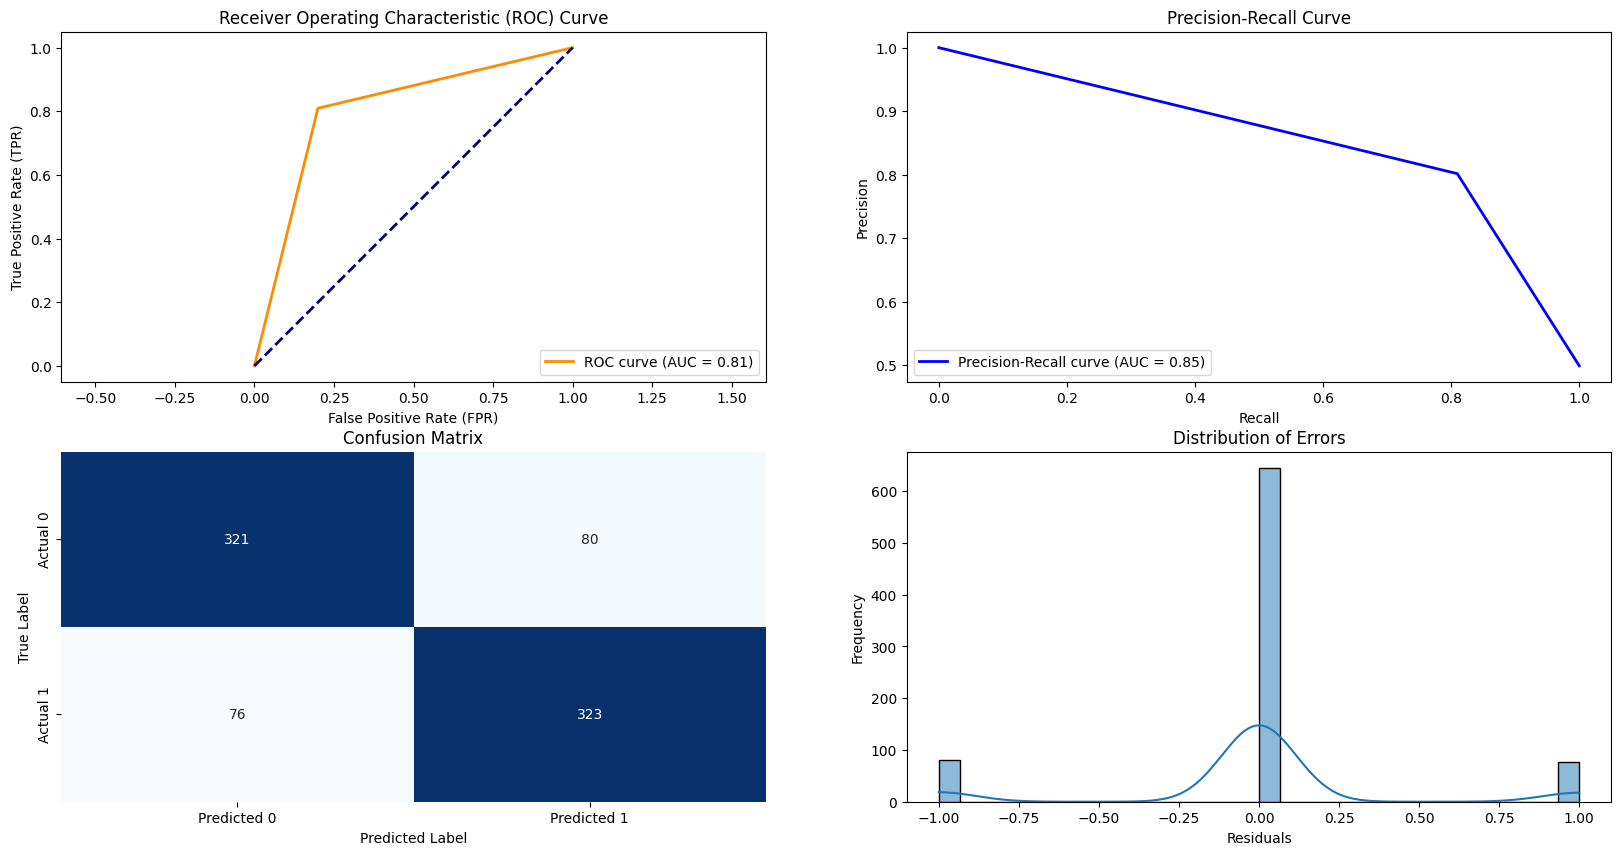

In [161]:
model = Model(DecisionTreeClassifier(), 'Decision Tree Classifier Scaled', scaled=True)
model.fit()
model.visualize_metrics()

In [162]:
metrics_DT = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT.to_frame().T])
print(metrics_DT)

Accuracy                                      0.805
Precision                                  0.801489
Recall                                     0.809524
F1-Score                                   0.805486
ROC AUC                                    0.805011
Confusion Matrix             [[321, 80], [76, 323]]
PR AUC                                     0.743824
Name                Decision Tree Classifier Scaled
dtype: object


### Best model

In [ ]:
param_grid = {
    'max_depth': [None, 5, 10, 15,20, 25],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit the model to the data (search for the best hyperparameters)
grid_search.fit(X_train, y_train)

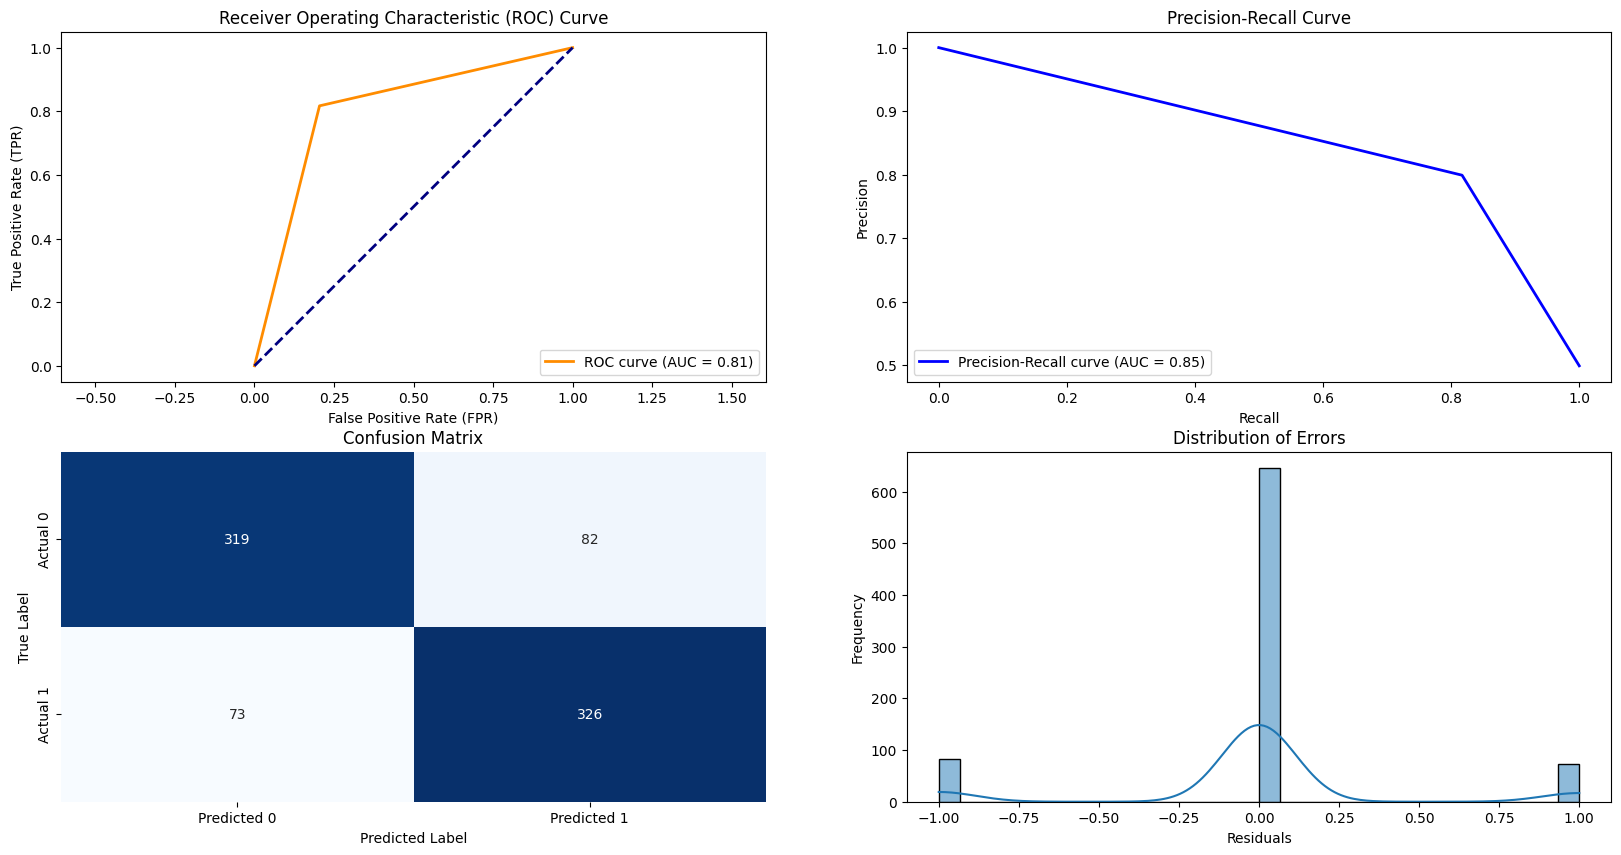

In [163]:
#{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}
model = Model(DecisionTreeClassifier(criterion='gini',max_depth=25, min_samples_leaf=1, min_samples_split=2), name='Grid Search Decision Tree Classifier')
model.fit()
model.visualize_metrics()

In [164]:
metrics_DT_Best = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT_Best.to_frame().T])
print(metrics_DT_Best)

Accuracy                                         0.80625
Precision                                        0.79902
Recall                                          0.817043
F1-Score                                        0.807931
ROC AUC                                         0.806277
Confusion Matrix                  [[319, 82], [73, 326]]
PR AUC                                          0.744083
Name                Grid Search Decision Tree Classifier
dtype: object


## SVC

Support Vector Machines (SVM) are a class of supervised learning algorithms used for both classification and regression tasks. The Support Vector Classification (SVC) model is specifically designed for classification problems. In SVC, the algorithm aims to find a hyperplane in a high-dimensional space that best separates the data into different classes. The term "support vector" refers to the data points that lie closest to the decision boundary (hyperplane), and these vectors play a crucial role in determining the optimal separation. The Key concepts are:
* <b>Hyperplane</b>: The decision boundary that separates the data points belonging to different classes. In a two-dimensional space, a hyperplane is a line; in higher dimensions, it becomes a hyperplane.
* <b>Support Vectors</b>: Data points that are closest to the hyperplane and influence the position and orientation of the decision boundary.
* <b>Margin</b>: The distance between the hyperplane and the nearest support vectors. A larger margin indicates a more robust separation.
* <b>Kernel Trick</b>: SVC can efficiently handle non-linear relationships in the data by using a kernel function to map the input data into a higher-dimensional space.



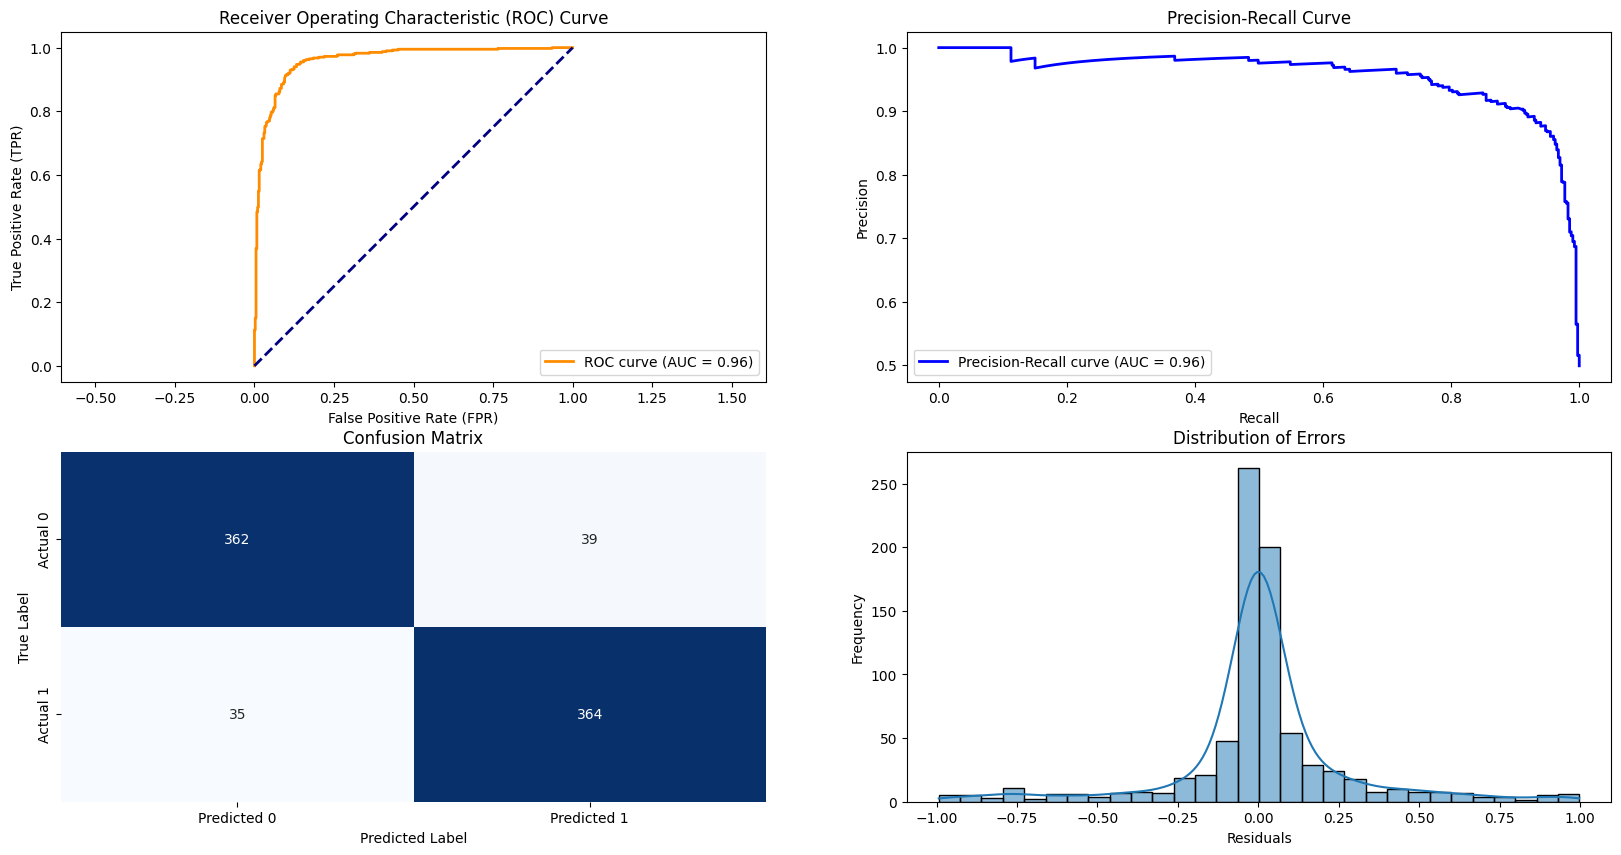

In [165]:
model = Model(SVC(probability=True), name='SVC')
model.fit()
model.visualize_metrics()

In [166]:
metrics_SVC = model.get_metrics()
models_df = pd.concat([models_df, metrics_SVC.to_frame().T])
print(metrics_SVC)

Accuracy                            0.9075
Precision                         0.903226
Recall                            0.912281
F1-Score                          0.907731
ROC AUC                           0.961237
Confusion Matrix    [[362, 39], [35, 364]]
PR AUC                               0.957
Name                                   SVC
dtype: object


### Scaled

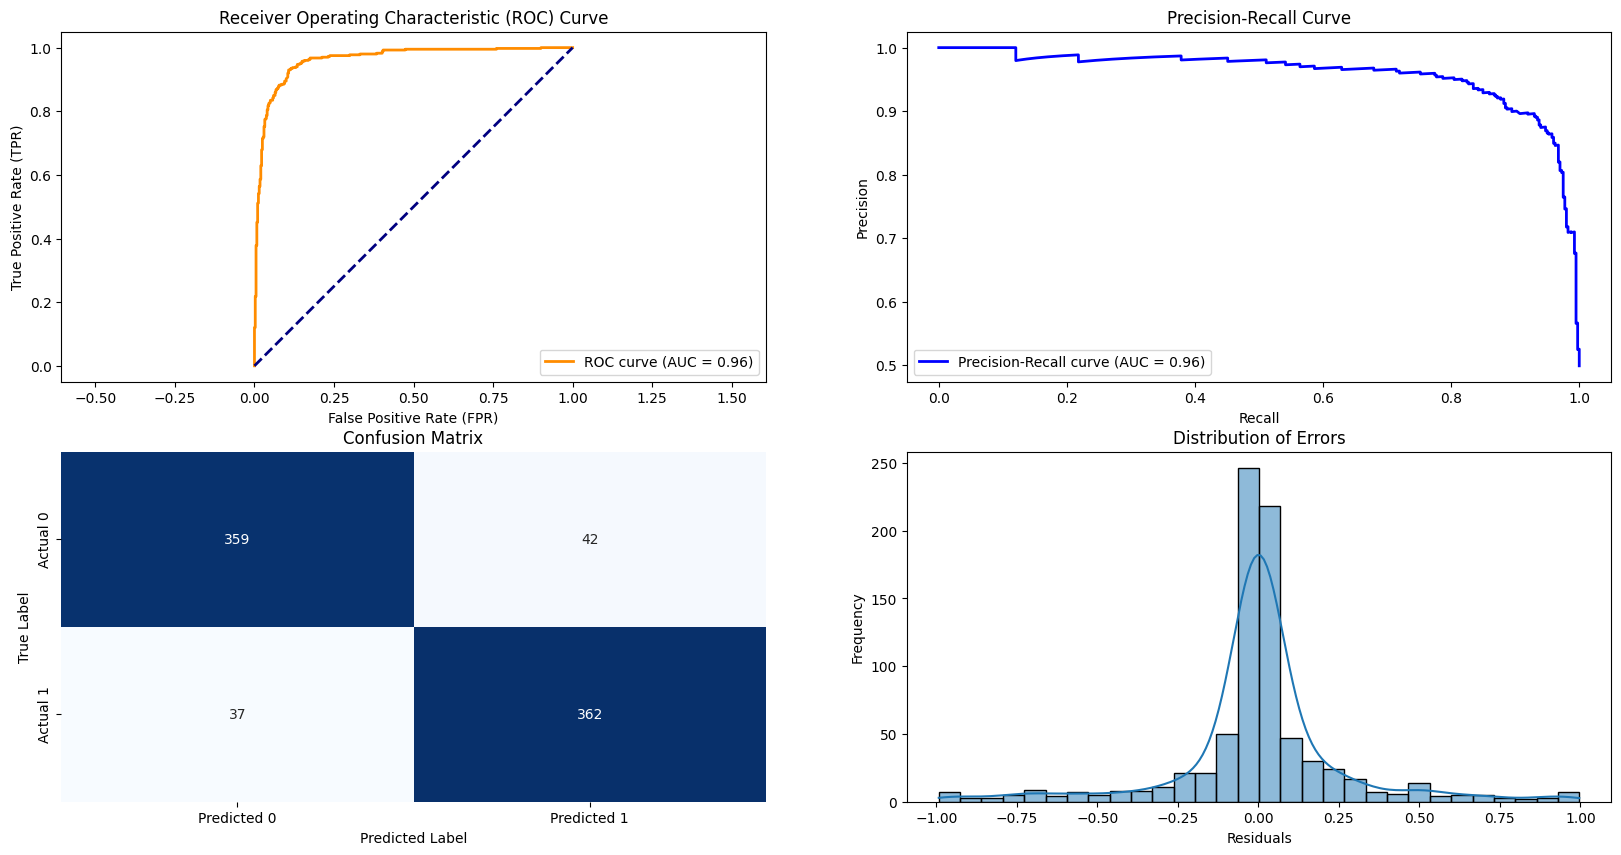

In [167]:
model = Model(SVC(probability=True), scaled=True, name='Scaled SVC')
model.fit()
model.visualize_metrics()

In [168]:
metrics_SVC = model.get_metrics()
models_df = pd.concat([models_df, metrics_SVC.to_frame().T])
print(metrics_SVC)

Accuracy                           0.90125
Precision                          0.89604
Recall                            0.907268
F1-Score                          0.901619
ROC AUC                           0.962512
Confusion Matrix    [[359, 42], [37, 362]]
PR AUC                            0.959242
Name                            Scaled SVC
dtype: object


### Best model

In [65]:
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

In [ ]:
print(grid.best_params_)
#SVC(C = 10, gamma=0.1, kernel='rbf')

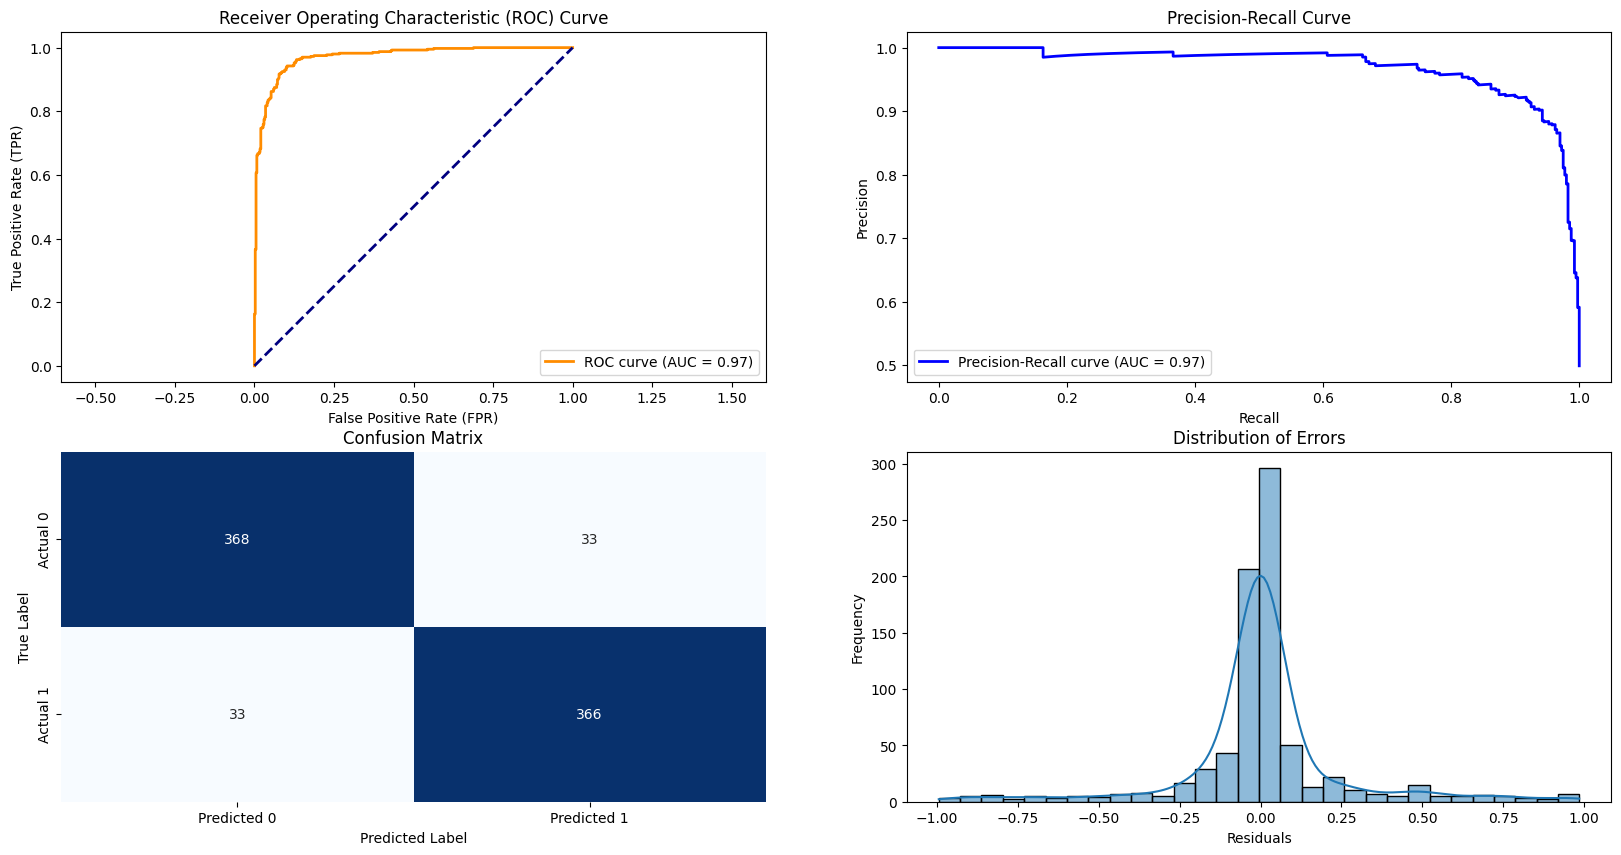

In [169]:
model = Model(SVC(C=10, gamma=0.1, kernel='rbf', probability=True), name='Grid Search SVC')
model.fit()
model.visualize_metrics()

In [170]:
metrics_SVC = model.get_metrics()
models_df = pd.concat([models_df, metrics_SVC.to_frame().T])
print(metrics_SVC)

Accuracy                            0.9175
Precision                         0.917293
Recall                            0.917293
F1-Score                          0.917293
ROC AUC                           0.970634
Confusion Matrix    [[368, 33], [33, 366]]
PR AUC                            0.969652
Name                       Grid Search SVC
dtype: object


## KNN

The K-Nearest Neighbors (K-NN) algorithm is a simple and intuitive supervised machine learning method used for both classification and regression tasks. It operates based on the principle that similar data points tend to share common characteristics and are often found close to each other in the feature space.
Here's a brief explanation of how K-NN works:
* <b>Data Representation</b>: Each data point in the dataset is represented as a point in a multi-dimensional space, where each dimension corresponds to a feature of the data.
* <b>Nearest Neighbors</b>: For a given data point, the algorithm identifies its k nearest neighbors in the feature space. The term "k" represents the number of neighbors to consider, and it is a user-defined parameter.
* <b>Classification (or Regression)</b>: For a classification task, the majority class among the k nearest neighbors is assigned to the data point. In the case of regression, the average (or another metric) of the target values of the k nearest neighbors is used as the predicted value.
* <b>Distance Measure</b>: The distance between data points is typically calculated using metrics such as Euclidean distance, Manhattan distance, or other distance measures, depending on the nature of the data.
* <b>Hyperparameter Tuning</b>: The choice of the parameter k is crucial in k-NN. A smaller value of k makes the model more sensitive to noise, while a larger k smoothens the decision boundaries. The optimal value of k often needs to be determined through cross-validation.

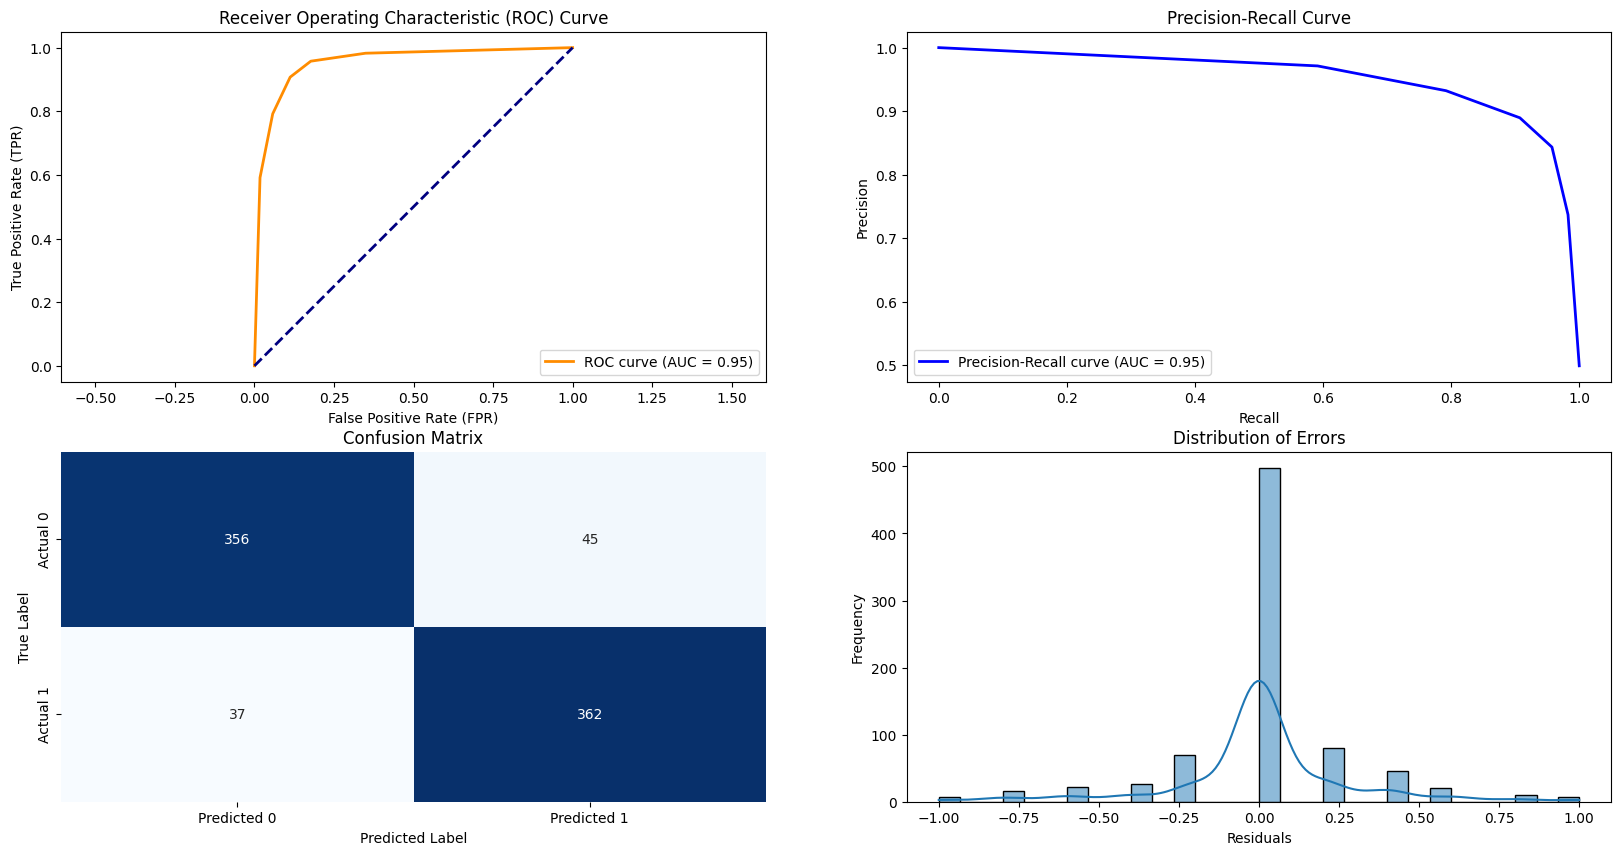

In [171]:
model = Model(KNeighborsClassifier(),'KNN')
model.fit()
model.visualize_metrics()

In [172]:
metrics_KNN = model.get_metrics()
models_df = pd.concat([models_df, metrics_KNN.to_frame().T])
print(metrics_KNN)

Accuracy                            0.8975
Precision                         0.889435
Recall                            0.907268
F1-Score                          0.898263
ROC AUC                           0.951884
Confusion Matrix    [[356, 45], [37, 362]]
PR AUC                            0.933366
Name                                   KNN
dtype: object


### Scaled

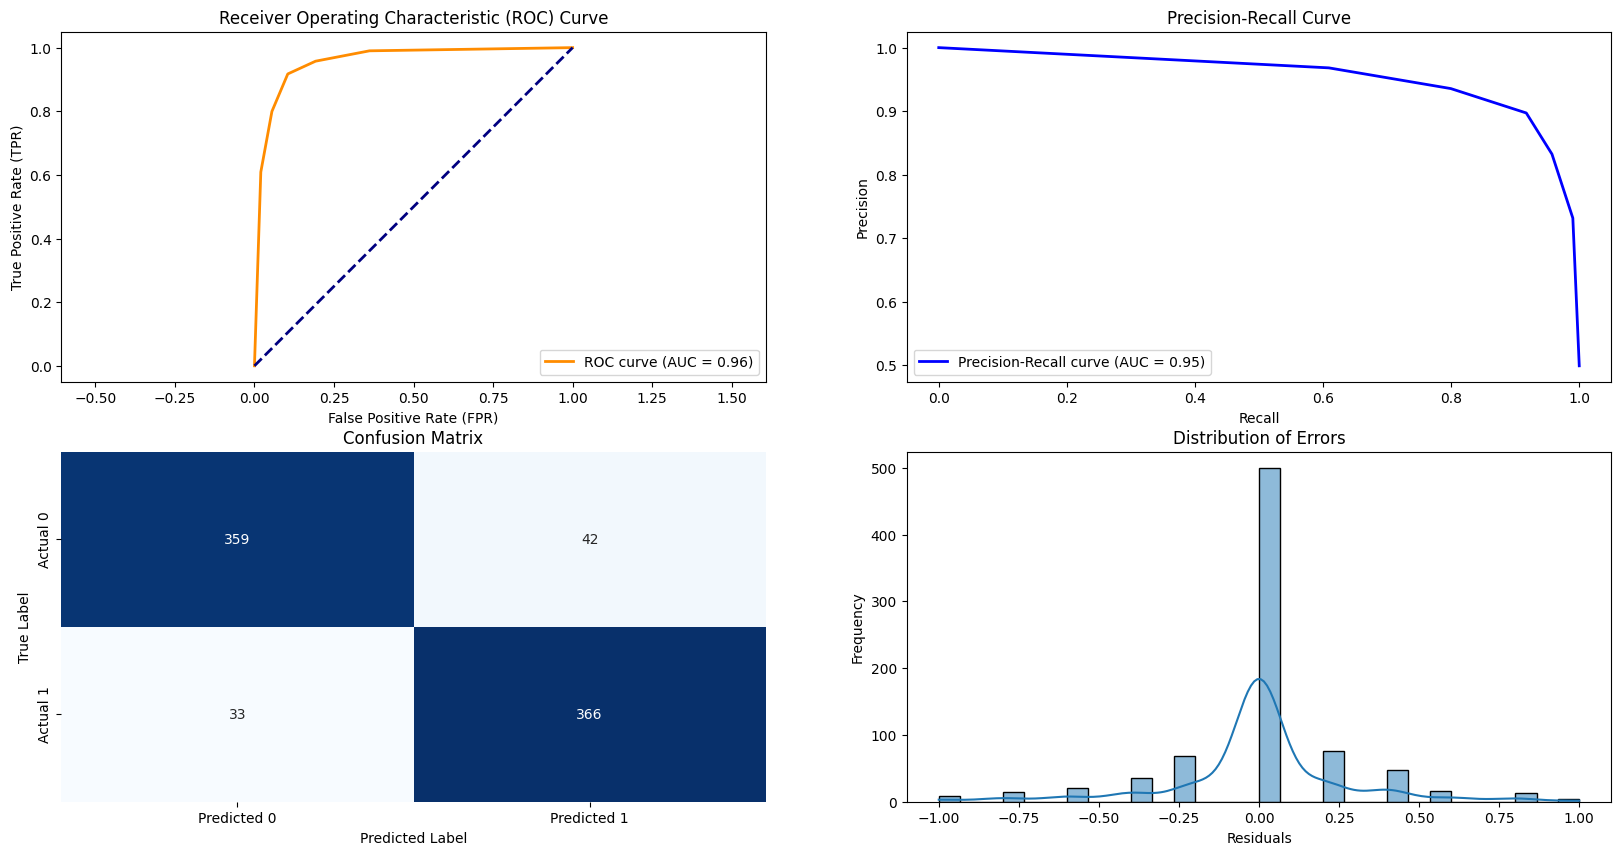

In [173]:
model = Model(KNeighborsClassifier(), scaled=True,name='KNN Scaled')
model.fit()
model.visualize_metrics()

In [174]:
metrics_KNN = model.get_metrics()
models_df = pd.concat([models_df, metrics_KNN.to_frame().T])
print(metrics_KNN)

Accuracy                           0.90625
Precision                         0.897059
Recall                            0.917293
F1-Score                          0.907063
ROC AUC                           0.955606
Confusion Matrix    [[359, 42], [33, 366]]
PR AUC                            0.935673
Name                            KNN Scaled
dtype: object


### Best Model

In [175]:
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

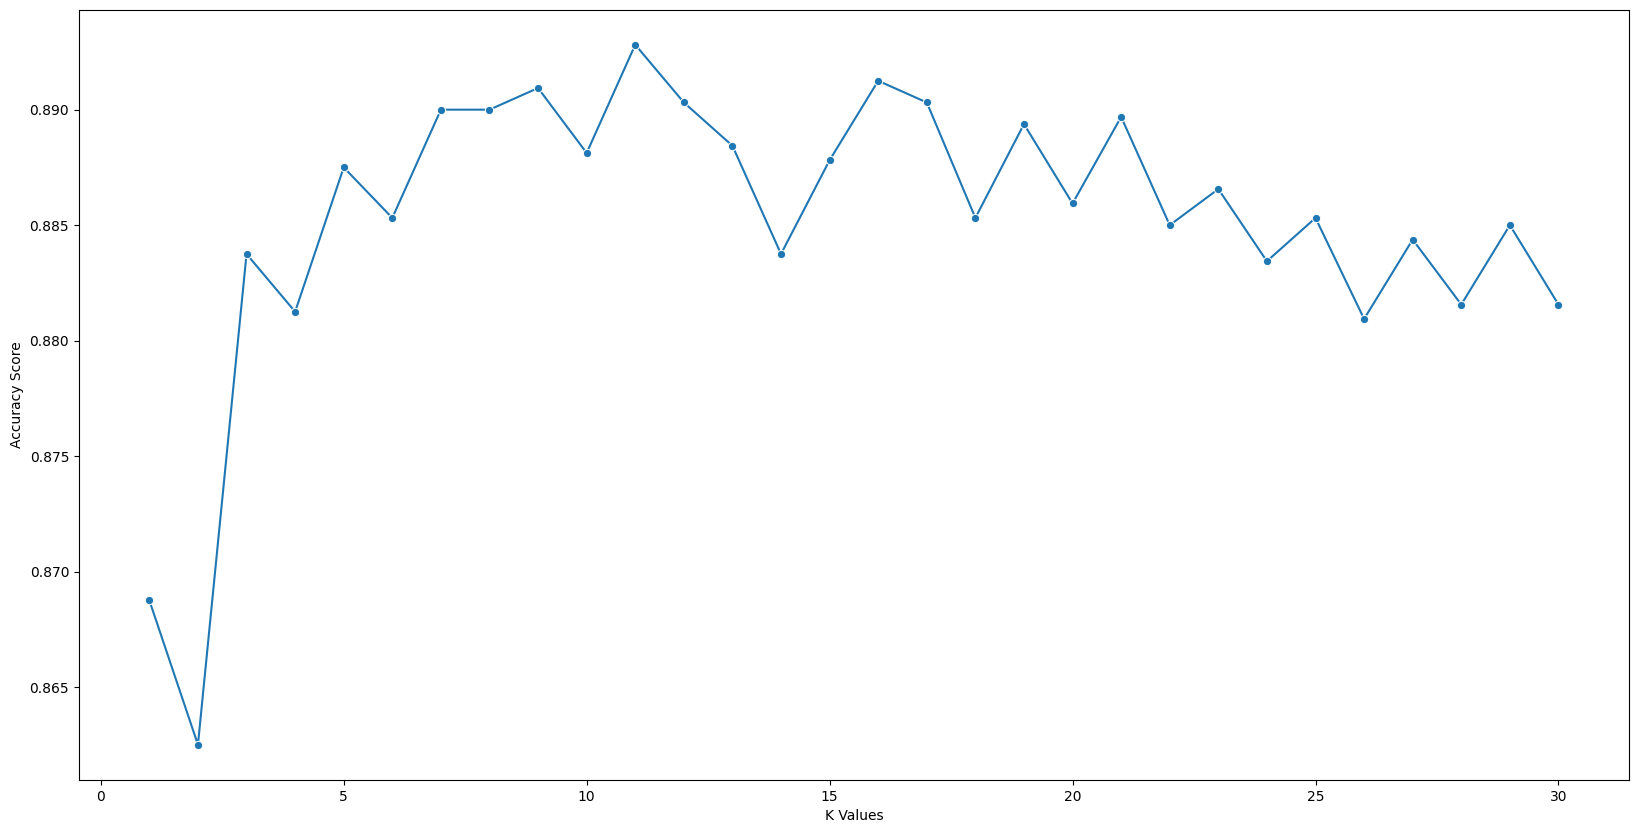

In [176]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [177]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
print(best_k)

11


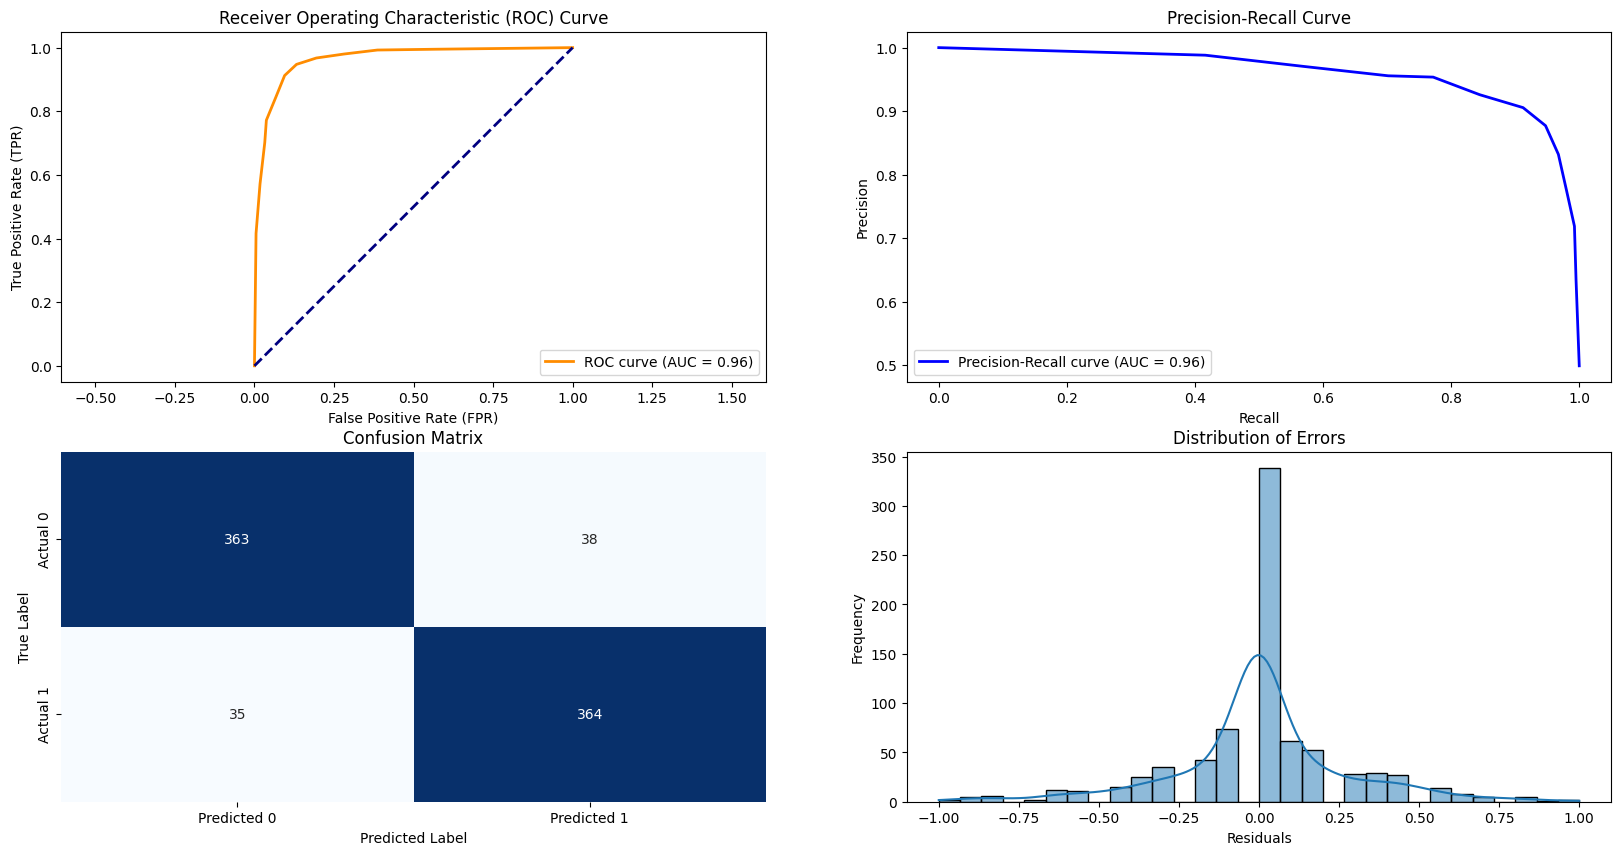

In [178]:
model = Model(KNeighborsClassifier(n_neighbors=best_k),scaled=True, name='Best KNN')
model.fit()
model.visualize_metrics()

In [179]:
metrics_KNN = model.get_metrics()
models_df = pd.concat([models_df, metrics_KNN.to_frame().T])
print(metrics_KNN)

Accuracy                           0.90875
Precision                         0.905473
Recall                            0.912281
F1-Score                          0.908864
ROC AUC                           0.962662
Confusion Matrix    [[363, 38], [35, 364]]
PR AUC                             0.95214
Name                              Best KNN
dtype: object


## Gradient Boosting Classifier

Gradient Boosting is an ensemble learning technique that combines the predictions of multiple weak learners (typically decision trees) to create a strong predictive model. The Gradient Boosting Classifier, specifically, is used for classification tasks.

Here's a brief description of the Gradient Boosting Classifier:

* <b>Base Learners (Weak Models)</b>: The algorithm starts with an initial weak learner, often a shallow decision tree. The model initially makes predictions, and the errors or residuals (the differences between predicted and actual values) are identified.
* <b>Gradient Descent Optimization</b>: In subsequent iterations, new weak learners are added to the ensemble, and they focus on correcting the errors made by the existing ensemble. The optimization process is akin to descending a gradient in the error space, hence the name "gradient boosting."
* <b>Weighted Contributions</b>: Each weak learner contributes to the final prediction with a certain weight. The weights are determined during the training process, and they depend on the contribution of each learner in minimizing the overall prediction error.
* <b>Shrinkage (Learning Rate)</b>: A hyperparameter called the learning rate controls the contribution of each weak learner. A smaller learning rate requires more weak learners but often leads to better generalization.
* <b>Regularizatio</b>>: Gradient Boosting includes regularization techniques to prevent overfitting. This may involve constraining the complexity of the individual weak learners or introducing penalties for large weights.
* <b>Prediction</b>: The final prediction is made by aggregating the predictions of all weak learners, and the class with the majority of votes is selected as the predicted class for classification tasks.

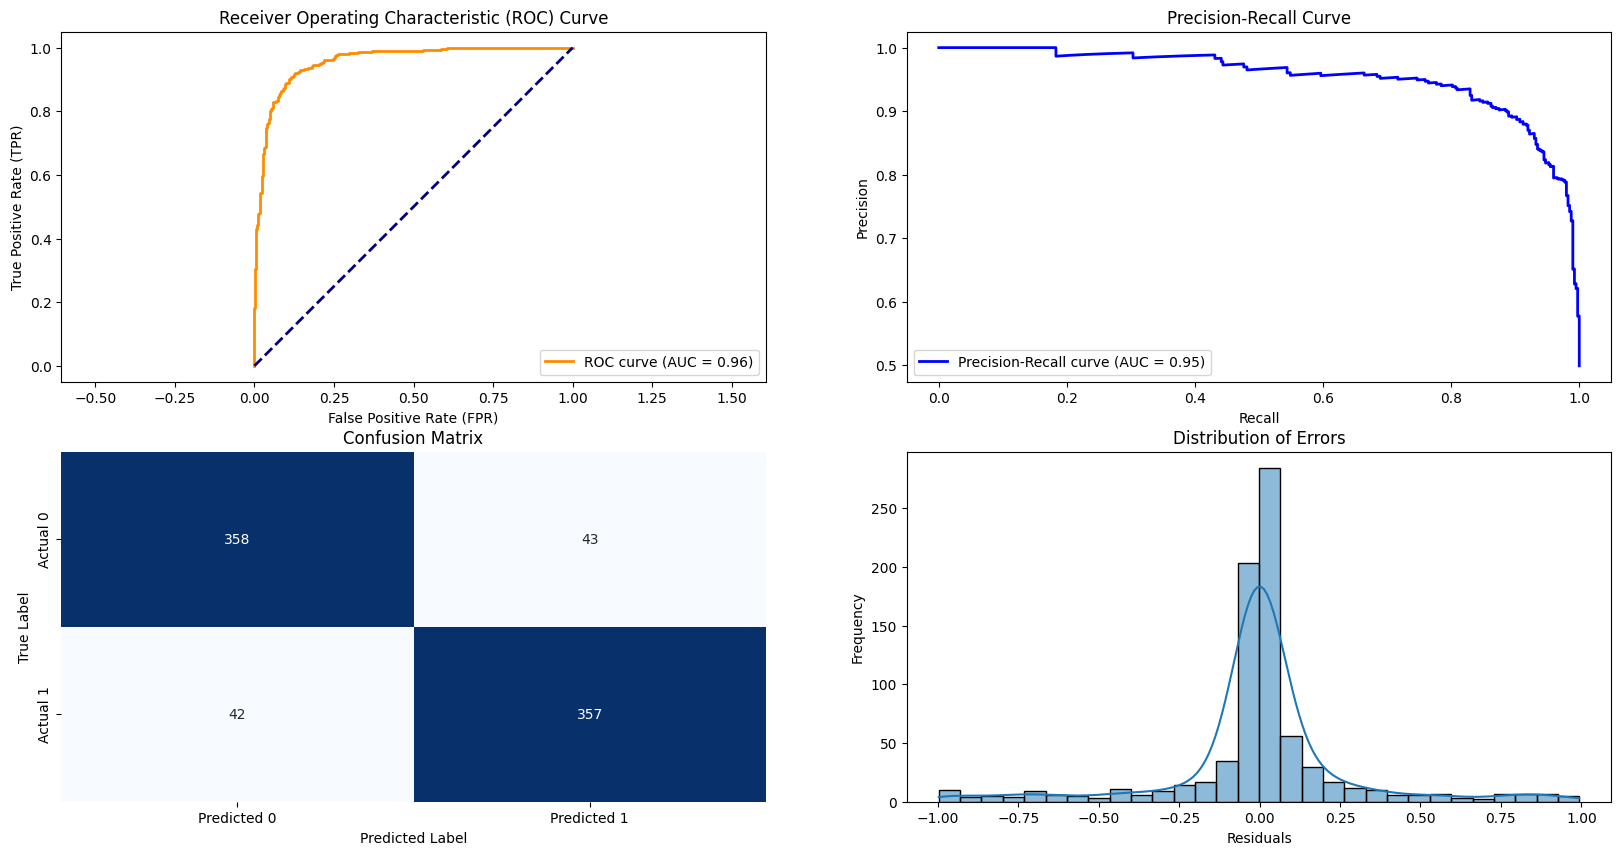

In [180]:
model = Model(GradientBoostingClassifier(n_estimators=200, learning_rate=0.2,max_depth=5,min_samples_leaf=50,
                                 min_samples_split=40,max_features='sqrt', random_state=42), name='Gradient Boosting Classifier')
model.fit()
model.visualize_metrics()

In [181]:
metrics_GBC = model.get_metrics()
models_df = pd.concat([models_df, metrics_GBC.to_frame().T])
print(metrics_GBC)

Accuracy                                 0.89375
Precision                                 0.8925
Recall                                  0.894737
F1-Score                                0.893617
ROC AUC                                 0.956981
Confusion Matrix          [[358, 43], [42, 357]]
PR AUC                                  0.954215
Name                Gradient Boosting Classifier
dtype: object


### Best model

In [91]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [35,50],
    'min_samples_split': [1,2,5],
    'min_samples_leaf': [5],
    'subsample': [0.8],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [ ]:
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

In [116]:
print(grid_search.best_params_)
#{'learning_rate': 0.2, 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}

{'learning_rate': 0.2, 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}


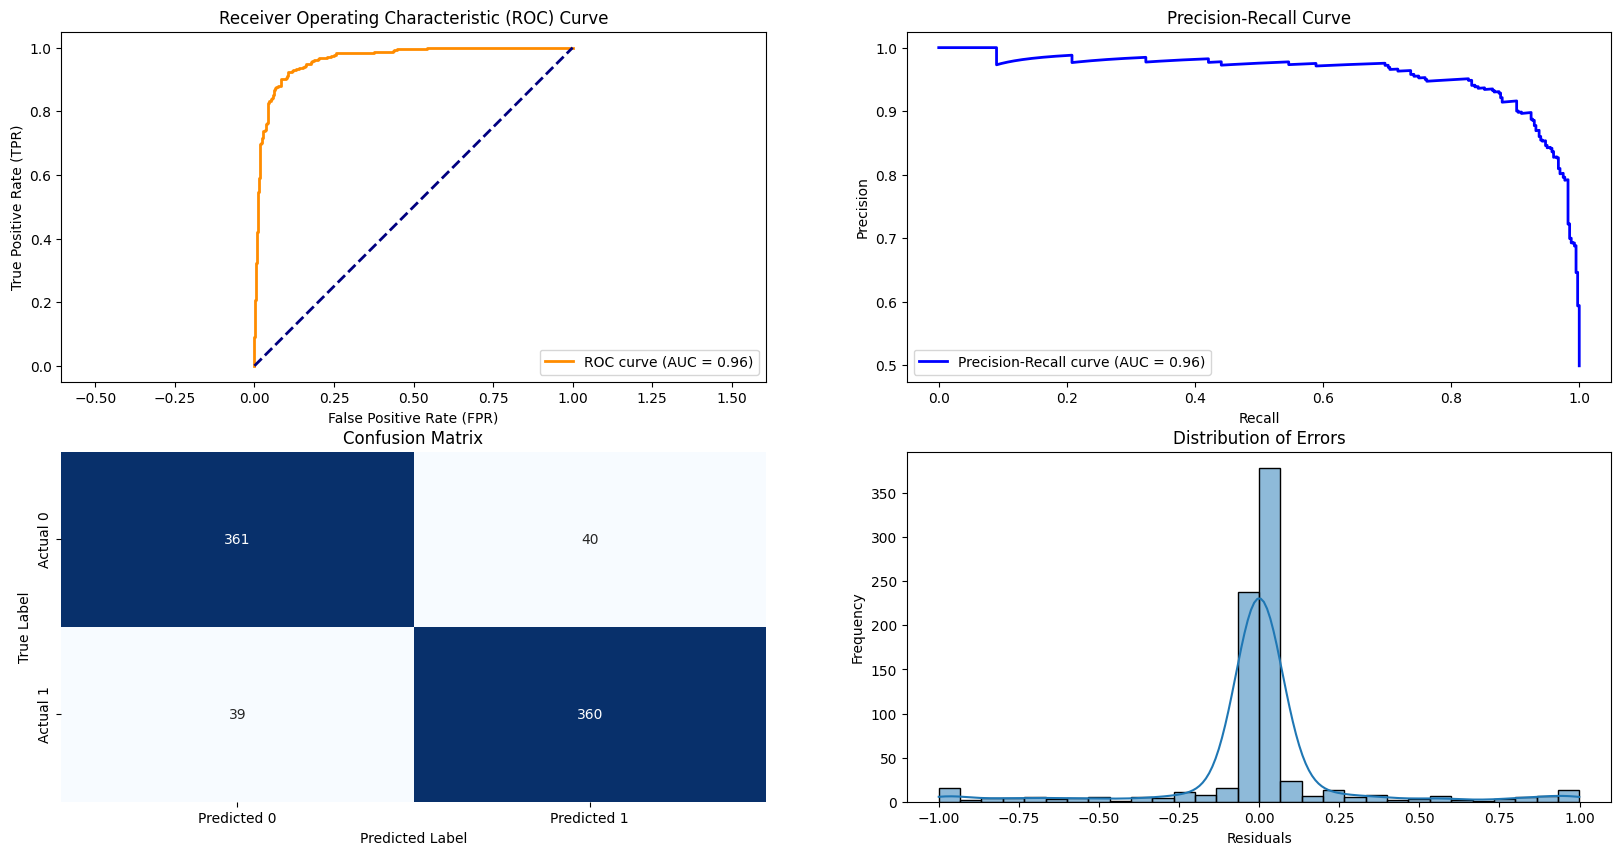

In [182]:
model = Model(GradientBoostingClassifier(n_estimators=50, learning_rate=0.2,max_depth=35,min_samples_leaf=5,
                                 min_samples_split=2,max_features='sqrt',subsample=0.8, random_state=42), name='Grid Search Gradient Boosting Classifier')
model.fit()
model.visualize_metrics()

In [183]:
metrics_GBC = model.get_metrics()
models_df = pd.concat([models_df, metrics_GBC.to_frame().T])
print(metrics_GBC)

Accuracy                                             0.90125
Precision                                                0.9
Recall                                              0.902256
F1-Score                                            0.901126
ROC AUC                                             0.963381
Confusion Matrix                      [[361, 40], [39, 360]]
PR AUC                                              0.958432
Name                Grid Search Gradient Boosting Classifier
dtype: object


# Deep Learning

## PyTorch

In [184]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [185]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Preparation of the data

In [186]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
test_ds = TensorDataset(X_test,y_test )
train_ds = TensorDataset(X_train, y_train)

### Creation of the model

In [92]:
class BinaryNNModel(nn.Module):
    def __init__(self,
                 input_features:int,
                 hidden_size:int,
                 dropout_rate:float,
                 output:int,
                 hidden_layers:int):
        super().__init__()
        #Input
        self.linear_stack = nn.Sequential(
            nn.Linear(input_features,2*hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate))
        for i in range(hidden_layers):
            self.linear_stack = self.linear_stack.append(nn.Linear((i+1)*(2)*hidden_size,(i+2)*(2)*hidden_size))
            self.linear_stack = self.linear_stack.append(nn.ReLU())
            self.linear_stack = self.linear_stack.append(nn.Dropout(dropout_rate))
        #Output Layer
        self.linear_stack = self.linear_stack.append(nn.Linear((hidden_layers+1)*2 * hidden_size,output))
        self.linear_stack.apply(custom_weights_init)
        self.float()

    def forward(self,x):
        return self.linear_stack(x)
def custom_weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        # You can use different initialization methods here
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

### Accuracy function

In [94]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Hyper parameters for best model

In [96]:
EPOCHS = [1000]
BATCH_SIZES = [40,80,160]
HIDDEN_SIZES = [2,3,4,5]
LAYERS = [1,2,3]
LEARNING_RATE = [0.01, 0.05, 0.1,0.2]

In [316]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Do not run
best_acc = 0
best_test_acc = 0
for epochs in EPOCHS:
    for batch_size in BATCH_SIZES:
        train_dl = DataLoader(train_ds, batch_size, shuffle=True)
        for hidden_size in HIDDEN_SIZES:
            for layer in LAYERS:
                for lr in LEARNING_RATE:
                    writer = SummaryWriter(log_dir=f'./runs/{batch_size}_{hidden_size}_{layer}_{lr}')
                    model = BinaryNNModel(input_features=X_train.shape[1],
                    hidden_size=hidden_size,
                    dropout_rate=.2,
                    output=1,
                    hidden_layers=layer)
                    loss_fn = nn.BCEWithLogitsLoss()
                    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
                    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
                    print('[START]',epochs, batch_size, hidden_size, layer, lr)
                    for epoch in range(epochs):
                        for x_batch, y_batch in train_dl:
                            y_logits = model(x_batch).squeeze()
                            output_prob = torch.sigmoid(y_logits)
                            y_pred = output_prob > 0.5
                            loss = loss_fn(y_logits, y_batch) 
                            acc = accuracy_fn(y_true=y_batch, y_pred=y_pred)

                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()
                        y_logits = model(X_test).squeeze()
                        output_prob = torch.sigmoid(y_logits)
                        y_pred = output_prob > 0.5
                        acc_test = accuracy_fn(y_true=y_test, y_pred=y_pred)
                        writer.add_scalar("Loss/train", loss, epoch)
                        writer.add_scalar("Accuracy/train", acc, epoch)
                        writer.add_scalar("Accuracy/test", acc_test, epoch)
                        if acc_test > best_test_acc:
                            best_test_acc = acc_test
                        if acc > best_acc:
                            best_acc = acc
                            torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            # Add other information you may want to save
                            }, f'./Weights/weights.torch')
                        if epoch % 10 == 0:
                            print(f"Epoch: {epoch} | Loss: {loss:.8f}, Accuracy: {acc:.2f}%")
                            for name, param in model.named_parameters():
                                writer.add_histogram(name, param, epoch)
                 


In [ ]:
print(best_test_acc)

The best model which achieved the accuracy above has:
* 160 batch size
* 8 hidden size
* 2 hidden layers
* 0.2 learning rate
* 983 epochs

In [98]:
model = BinaryNNModel(input_features=X_train.shape[1],
                    hidden_size=8,
                    dropout_rate=.2,
                    output=1,
                    hidden_layers=2)
loss_fn = nn.BCEWithLogitsLoss()
train_dl = DataLoader(train_ds, 160, shuffle=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.2)
best_test_acc = 0
for epoch in range(1000):
    for x_batch, y_batch in train_dl:
        y_logits = model(x_batch).squeeze()
        output_prob = torch.sigmoid(y_logits)
        y_pred = output_prob > 0.5
        loss = loss_fn(y_logits, y_batch) 
        acc = accuracy_fn(y_true=y_batch, y_pred=y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    y_logits = model(X_test).squeeze()
    output_prob = torch.sigmoid(y_logits)
    y_proba = output_prob.detach().numpy()
    y_pred = output_prob > 0.5
    accuracy = metrics.accuracy_score(y_test, y_pred)
    if accuracy > best_test_acc:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # Add other information you may want to save
            }, f'./Weights/weights_best.torch')
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.8f}, Accuracy: {acc:.2f}%")

Epoch: 0 | Loss: 0.56188452, Accuracy: 70.62%
Epoch: 10 | Loss: 0.50407225, Accuracy: 77.50%
Epoch: 20 | Loss: 0.34837478, Accuracy: 83.75%
Epoch: 30 | Loss: 0.37583241, Accuracy: 84.38%
Epoch: 40 | Loss: 0.30177340, Accuracy: 87.50%
Epoch: 50 | Loss: 0.32038459, Accuracy: 88.12%
Epoch: 60 | Loss: 0.24157481, Accuracy: 91.88%
Epoch: 70 | Loss: 0.26460996, Accuracy: 88.12%
Epoch: 80 | Loss: 0.36083704, Accuracy: 85.62%
Epoch: 90 | Loss: 0.18380709, Accuracy: 93.75%
Epoch: 100 | Loss: 0.19202422, Accuracy: 90.62%
Epoch: 110 | Loss: 0.16867766, Accuracy: 92.50%
Epoch: 120 | Loss: 0.20848069, Accuracy: 93.12%
Epoch: 130 | Loss: 0.28153229, Accuracy: 90.62%
Epoch: 140 | Loss: 0.18602791, Accuracy: 91.25%
Epoch: 150 | Loss: 0.21746559, Accuracy: 89.38%
Epoch: 160 | Loss: 0.18228212, Accuracy: 93.12%
Epoch: 170 | Loss: 0.20641129, Accuracy: 94.38%
Epoch: 180 | Loss: 0.21348718, Accuracy: 89.38%
Epoch: 190 | Loss: 0.26685888, Accuracy: 88.75%
Epoch: 200 | Loss: 0.16066761, Accuracy: 93.12%
Epo

In [99]:
model.load_state_dict(torch.load('./Weights/weights_best.torch'),strict=False)
model.eval()

BinaryNNModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=48, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=48, out_features=1, bias=True)
  )
)

In [100]:
y_logits = model(X_test).squeeze()
output_prob = torch.sigmoid(y_logits)
y_proba = output_prob.detach().numpy()
y_pred = output_prob > 0.5

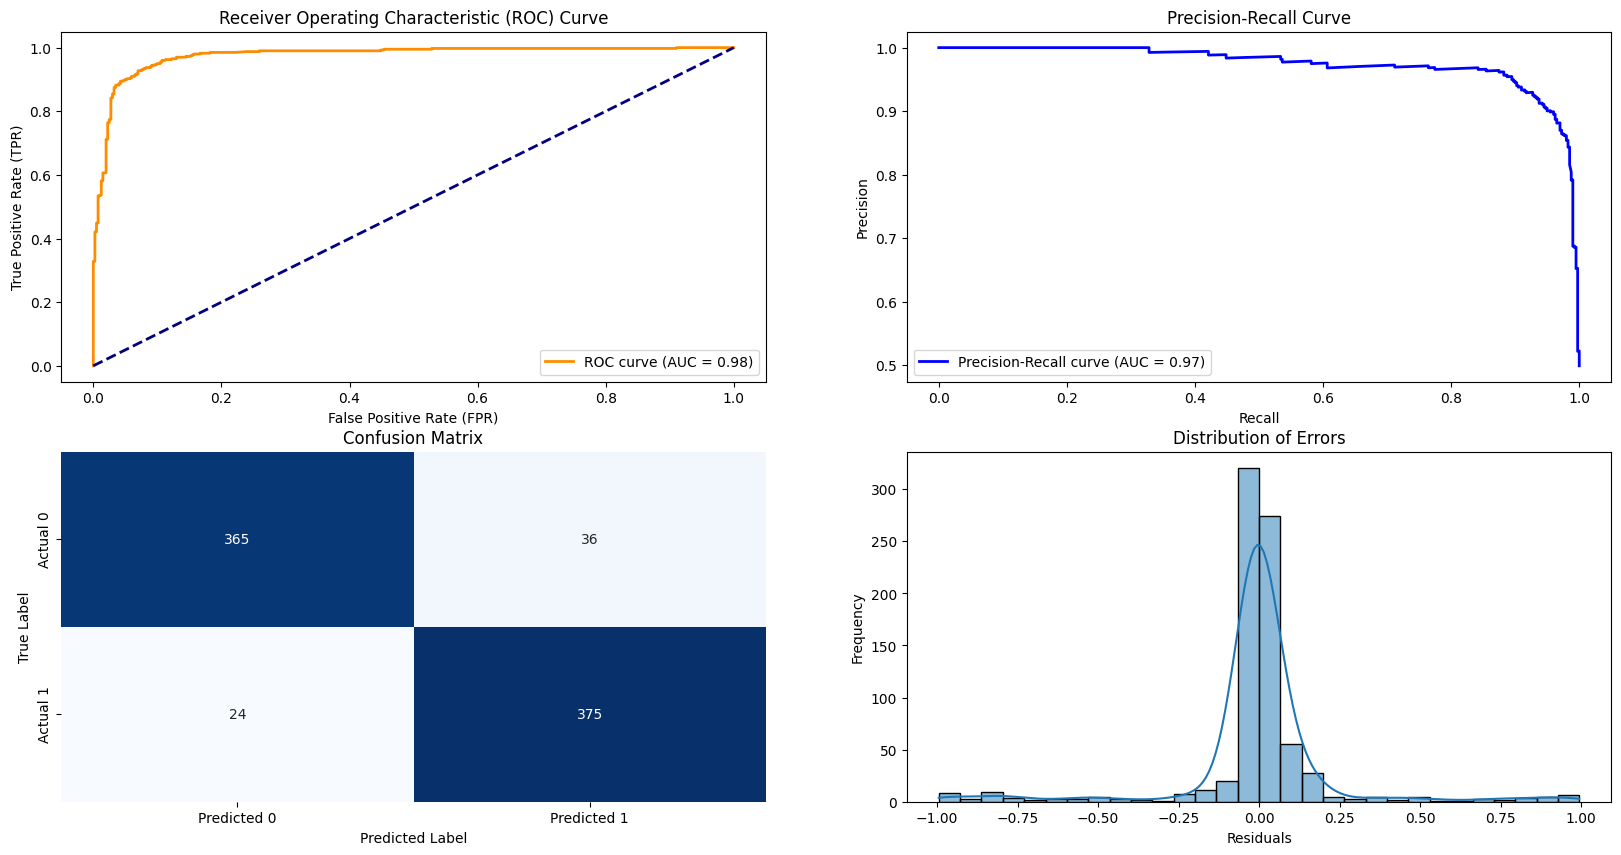

In [101]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.roc_auc_score(y_test, y_proba)
# Calculate Precision-Recall curve and AUC
precision, recall, _ = metrics.precision_recall_curve(y_test, y_proba)
pr_auc = metrics.auc(recall, precision)
# Plot ROC curve
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
plt.subplot(2, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

residuals = y_test - y_proba
# Plot Confusion Matrix and Distribution of errors
plt.subplot(2, 2, 3)
conf_mat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.subplot(2, 2, 4)
sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Errors')
plt.show()

In [102]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_proba)
conf_mat = metrics.confusion_matrix(y_test, y_pred)
pr_auc = metrics.average_precision_score(y_test, y_proba)
metrics_NN = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name': 'PyTorch Best Model'
})
models_df = pd.concat([models_df, metrics_NN.to_frame().T])
print(metrics_NN)

Accuracy                             0.925
Precision                         0.912409
Recall                             0.93985
F1-Score                          0.925926
ROC AUC                           0.975065
PR AUC                            0.974014
Confusion Matrix    [[365, 36], [24, 375]]
Name                    PyTorch Best Model
dtype: object


## TensorFlow

In [103]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
tf.random.set_seed(42)

/Users/mattia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [104]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Best models "By hands"

After many trials i've find a model which has a better accuracy with a value of 96.875%. The model is with 2 hidden layers and the structure is the following

In [187]:
features_in = X_train.shape[1]
initializer = tf.keras.initializers.GlorotNormal(42)
input_layer = Input(shape = (features_in, ))
layer1 = Dense(units = 24, activation = 'relu', kernel_initializer=initializer)(input_layer)
layer2 = Dense(units = 12, activation = 'relu',kernel_initializer=initializer)(layer1)
layer3 = Dense(units = 6, activation = 'relu',kernel_initializer=initializer)(layer2)
output_layer = Dense(units = 1, activation = 'sigmoid')(layer3)
model = Model(inputs = input_layer, outputs = output_layer, name = 'Binary_Class')
model.summary()

TypeError: __init__() got an unexpected keyword argument 'inputs'

### Training

In [ ]:
## DO NOT RUN
features_in = X_train.shape[1]
best_acc = 0
best_i = 0
for i in range(100):
    initializer = tf.keras.initializers.GlorotNormal(42)
    input_layer = Input(shape = (features_in, ))
    layer1 = Dense(units = 24, activation = 'relu', kernel_initializer=initializer)(input_layer)
    layer2 = Dense(units = 12, activation = 'relu',kernel_initializer=initializer)(layer1)
    layer3 = Dense(units = 6, activation = 'relu',kernel_initializer=initializer)(layer2)
    output_layer = Dense(units = 1, activation = 'sigmoid')(layer3)
    model = Model(inputs = input_layer, outputs = output_layer, name = 'Binary_Class')

    model.compile(optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.2), 
                loss = tf.keras.losses.BinaryCrossentropy(), 
                metrics = "accuracy")
    model_checkpoint = ModelCheckpoint(f'./best_models/best_model_{i}.h', 
                                    monitor = 'val_loss', 
                                    save_best_only = True, verbose=0)
    history = model.fit(x = X_train, y = y_train, 
                    batch_size = 32, epochs = 600, verbose = 0, 
                    callbacks = [model_checkpoint], 
                    shuffle = True,
                    validation_data = (X_test, y_test))
    ## Load best model
    loaded_model = load_model(f"./best_models/best_model_{i}.h")

    #Calculate test predictions
    y_pred_prob_test = loaded_model.predict(X_test)
    y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
    acc_test = metrics.accuracy_score(y_test, y_pred_test)
    print(acc_test)
    if acc_test > best_acc:
        best_acc = acc_test
        best_i = i


Load the best evaluation for each run and compare them to get the best one.

In [188]:
best_acc = 0
for i in range(100):
    loaded_model = load_model(f"./best_models/best_model_{i}.h")

    #Calculate test predictions
    y_pred_prob_test = loaded_model.predict(X_test)
    y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
    acc_test = metrics.accuracy_score(y_test, y_pred_test)
    print(acc_test)
    if acc_test > best_acc:
        best_acc = acc_test
        best_i = i
print(best_i, best_acc)

TypeError: Cannot convert the argument `type_value`: torch.float32 to a TensorFlow DType.

The best model is the 93th with an accuracy of 96.875%. After this let's plot the training and the test performance of the model

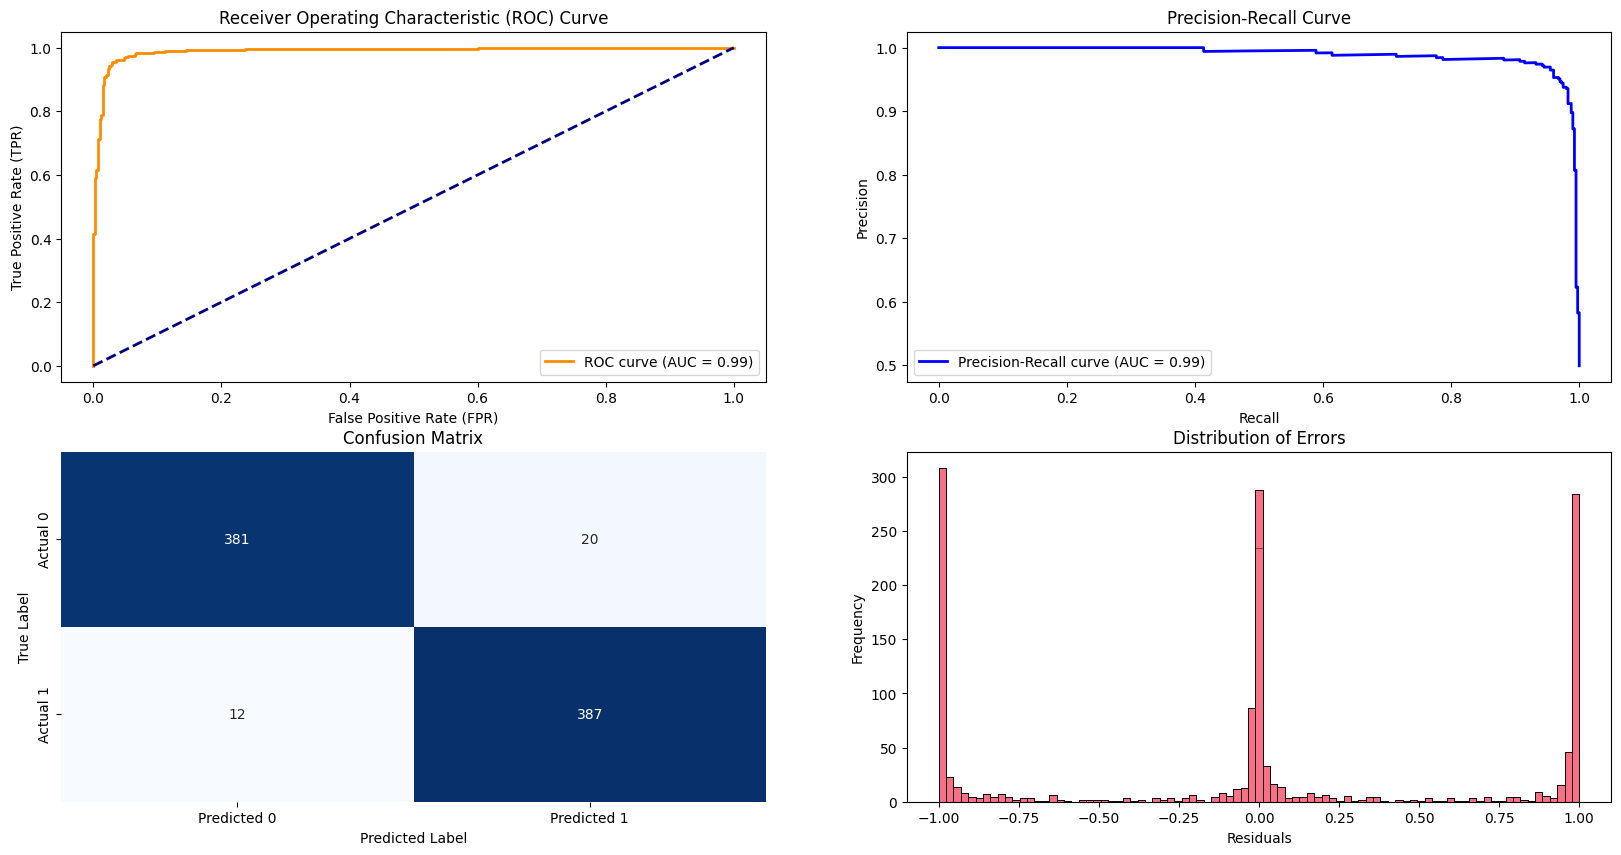

In [110]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
# Calculate Precision-Recall curve and AUC
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_prob_test)
pr_auc = metrics.auc(recall, precision)
# Plot ROC curve
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
plt.subplot(2, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

residuals = y_test - y_pred_prob_test
# Plot Confusion Matrix and Distribution of errors
plt.subplot(2, 2, 3)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.subplot(2, 2, 4)
sns.histplot(residuals, edgecolor='black')
plt.legend('',frameon=False)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Errors')
plt.show()

In [114]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'TF Best Model'
})
models_df = pd.concat([models_df, metrics_TF.to_frame().T])
print(metrics_TF)

Accuracy                              0.96
Precision                          0.95086
Recall                            0.969925
F1-Score                          0.960298
ROC AUC                           0.988475
PR AUC                            0.988522
Confusion Matrix    [[381, 20], [12, 387]]
Name                         TF Best Model
dtype: object


# Model Comparison

In [115]:
models_df

Name Accuracy Precision    Recall  \
0                LinearDiscriminantAnalysis   0.7575  0.751843  0.766917   
0                      Gaussian Naive Bayes   0.7625  0.770026  0.746867   
0                     Bernoulli Naive Bayes  0.70125  0.709424  0.679198   
0                       Logistic Regression  0.75375  0.753769   0.75188   
0                Logistic Regression Scaled  0.75875  0.752451  0.769424   
0           Grid Search Logistic Regression  0.75375  0.753769   0.75188   
0                  Decision Tree Classifier   0.8125  0.808933  0.817043   
0           Decision Tree Classifier Scaled  0.80375   0.80402  0.802005   
0      Grid Search Decision Tree Classifier   0.8125  0.808933  0.817043   
0                                       SVC   0.9075  0.903226  0.912281   
0                                Scaled SVC  0.90125   0.89604  0.907268   
0                           Grid Search SVC   0.9175  0.917293  0.917293   
0                                       KNN   0.8975  0.889435  0.907268   
0                                KNN Scaled  0.90625  0.897059  0.917293   
0                                  Best KNN  0.90875  0.905473  0.912281   
0              Gradient Boosting Classifier  0.89375    0.8925  0.894737   
0  Grid Search Gradient Boosting Classifier  0.90125       0.9  0.902256   
0                        PyTorch Best Model    0.925  0.912409   0.93985   
0                             TF Best Model     0.96   0.95086  0.969925   
0                             TF Best Model     0.96   0.95086  0.969925   
0                             TF Best Model     0.96   0.95086  0.969925   
0                             TF Best Model     0.96   0.95086  0.969925   

   F1-Score   ROC AUC          Confusion Matrix    PR AUC  
0  0.759305  0.822668   [[300, 101], [93, 306]]  0.790227  
0   0.75827  0.850899   [[312, 89], [101, 298]]  0.846821  
0  0.693982  0.759252  [[290, 111], [128, 271]]  0.737735  
0  0.752823   0.82313    [[303, 98], [99, 300]]  0.790266  
0  0.760843  0.823249   [[300, 101], [92, 307]]  0.790764  
0  0.752823  0.823149    [[303, 98], [99, 300]]  0.790336  
0  0.812968  0.812511    [[324, 77], [73, 326]]  0.752183  
0  0.803011  0.803746    [[323, 78], [79, 320]]  0.743578  
0  0.812968  0.812511    [[324, 77], [73, 326]]  0.752183  
0  0.907731  0.961244    [[362, 39], [35, 364]]  0.957008  
0  0.901619  0.962512    [[359, 42], [37, 362]]  0.959242  
0  0.917293  0.970631    [[368, 33], [33, 366]]  0.969646  
0  0.898263  0.951884    [[356, 45], [37, 362]]  0.933366  
0  0.907063  0.955606    [[359, 42], [33, 366]]  0.935673  
0  0.908864  0.962662    [[363, 38], [35, 364]]   0.95214  
0  0.893617  0.956981    [[358, 43], [42, 357]]  0.954215  
0  0.901126  0.963381    [[361, 40], [39, 360]]  0.958432  
0  0.925926  0.975065    [[365, 36], [24, 375]]  0.974014  
0  0.960298  0.988475    [[381, 20], [12, 387]]  0.988522  
0  0.960298  0.988475    [[381, 20], [12, 387]]  0.988522  
0  0.960298  0.988475    [[381, 20], [12, 387]]  0.988522  
0  0.960298  0.988475    [[381, 20], [12, 387]]  0.988522

In [116]:
models_df.index = models_df.Name
models_df = models_df.drop('Name',axis=1)

<Axes: xlabel='Name'>

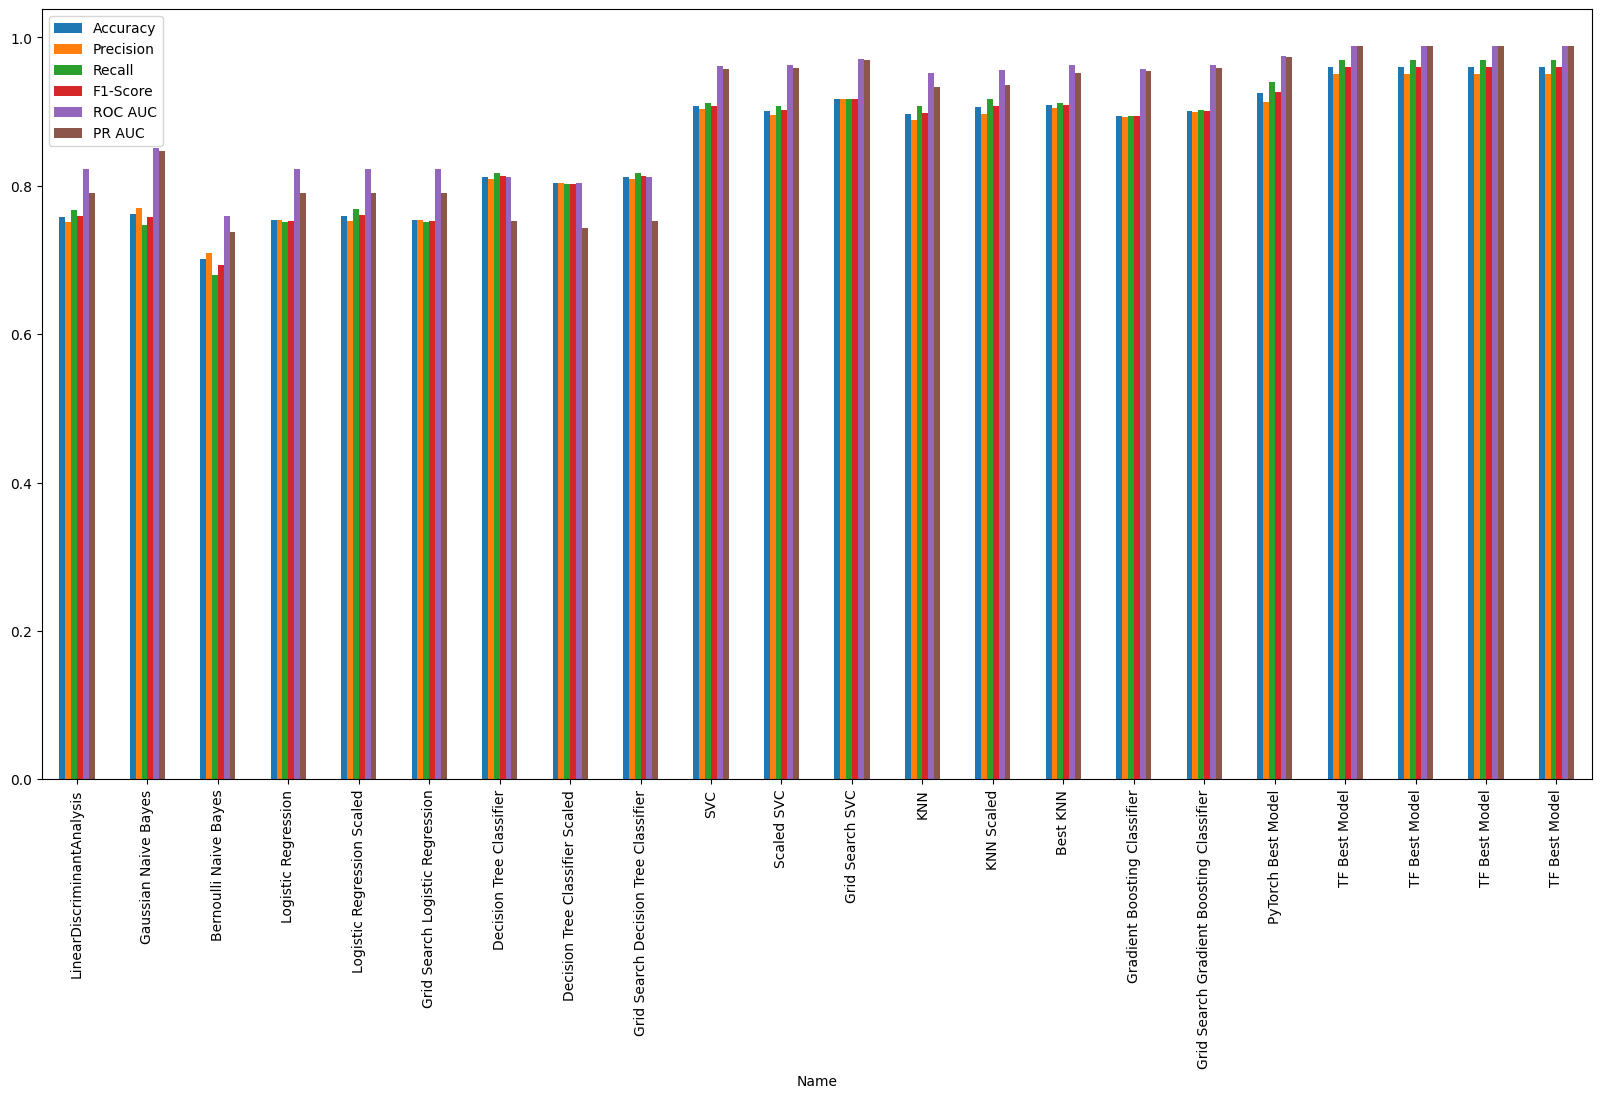

In [117]:
df = models_df[[x for x in models_df.columns if x != 'Confusion Matrix']]
df.plot.bar(figsize=(20,10))

# Highest  in each role

In [118]:
for col in models_df.columns:
    if col != 'Confusion Matrix':
        print(models_df.sort_values(by=col, ascending=False)[col].head(1))

Name
TF Best Model    0.96
Name: Accuracy, dtype: object
Name
TF Best Model    0.95086
Name: Precision, dtype: object
Name
TF Best Model    0.969925
Name: Recall, dtype: object
Name
TF Best Model    0.960298
Name: F1-Score, dtype: object
Name
TF Best Model    0.988475
Name: ROC AUC, dtype: object
Name
TF Best Model    0.988522
Name: PR AUC, dtype: object
